In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.linear_model import LogisticRegression, Ridge, Lasso
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.feature_selection import RFE
import statsmodels.api as sm
from imblearn.over_sampling import SMOTENC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from IPython.display import Image  
from six import StringIO
from sklearn.tree import export_graphviz
import pydotplus, graphviz
import calendar

In [2]:
tele = pd.read_csv('telecom_churn_data.csv')

To be done:
1. Identify prepaid and filter- ???
2. Churn Type: Keep only usage based and remove revenue based- ???
3. Delete unnecessary columns - Single val., check for those with single val, nan (cannot impute anyway so can remove)
4. Missing value imputation
5. Checking and removing outliers
6. See which cols are correlated and remove/derive new features wherever possible - {onnet,t2t,t2f} and {offnet,t2m,t2o} (based on data dictionary)  
7. Derive Churn:
For each month:
- Calculate tot. ic and tot. og. mou (total_ic_mou and total_og_mou)
- Calculate 2G and 3G data consumption (include recharge as well) (vol_2g_mb, vol_3g_mb)
- Sum up the two - If value =0 then churn else not churn, for month 9 --- Target Var. 
- Delete required cols (cols that are used to derive new features)
8. Check Churn % - If imbalanced - do SMOTE
9. Filter out only High Value customers
- Tot rech amt = Call rech amt + tot. data rech amt (tot. data rech amt = avg_rech_amt_data * tot_rech_data)
- Calculate avg recharge amt (June and July) - In real time, there will be lag in obtaining complete data and therefore taking only June and July
- Retain only those customers who have recharged >= 70th percentile 
10. EDA - Univariate (boxplot, bar chart), bivariate (scatter plots, stacked bar chart, two way table), multivariate (box plots), correlation (corr matrix, pairplots) 
11. Data Preparation (Maybe do before EDA) - Converting to categorical, create dummy variables, fix errors in data if needed
12. Modelling:
- Train-test split
- PCA
- Fitting models:
    - Logistic Regression (before PCA but after RFE?) {Includes hyperparameter tuning}
    - SVM {Includes hyperparameter tuning}
    - Decision Tree {Includes hyperparameter tuning}
    - Ensemble Models: Random Forest, (if required) - bagging, boosting {Includes hyperparameter tuning}
13. Model Selection - Based on eval. metrics of eacg (make plots)
14. Final model and predictions, most influencing vars.

## Data Exploration

In [3]:
tele.head()

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,...,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g
0,7000842753,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,197.385,...,0,1.0,1.0,1.0,NaN,968,30.4,0.0,101.20,3.58
1,7001865778,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,34.047,...,0,NaN,1.0,1.0,NaN,1006,0.0,0.0,0.00,0.00
2,7001625959,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,167.690,...,0,NaN,NaN,NaN,1.0,1103,0.0,0.0,4.17,0.00
3,7001204172,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,221.338,...,0,NaN,NaN,NaN,NaN,2491,0.0,0.0,0.00,0.00
4,7000142493,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,261.636,...,0,0.0,NaN,NaN,NaN,1526,0.0,0.0,0.00,0.00


In [4]:
tele.shape

(99999, 226)

In [5]:
tele.describe()

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,arpu_6,arpu_7,arpu_8,arpu_9,onnet_mou_6,...,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g
count,9.999900e+04,99999.0,98981.0,98981.0,98981.0,99999.000000,99999.000000,99999.000000,99999.000000,96062.000000,...,99999.000000,25153.000000,25571.000000,26339.000000,25922.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000
mean,7.001207e+09,109.0,0.0,0.0,0.0,282.987358,278.536648,279.154731,261.645069,132.395875,...,0.084581,0.914404,0.908764,0.890808,0.860968,1219.854749,68.170248,66.839062,60.021204,3.299373
std,6.956694e+05,0.0,0.0,0.0,0.0,328.439770,338.156291,344.474791,341.998630,297.207406,...,0.650457,0.279772,0.287950,0.311885,0.345987,954.733842,267.580450,271.201856,253.938223,32.408353
min,7.000000e+09,109.0,0.0,0.0,0.0,-2258.709000,-2014.045000,-945.808000,-1899.505000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,180.000000,0.000000,0.000000,0.000000,0.000000
25%,7.000606e+09,109.0,0.0,0.0,0.0,93.411500,86.980500,84.126000,62.685000,7.380000,...,0.000000,1.000000,1.000000,1.000000,1.000000,467.000000,0.000000,0.000000,0.000000,0.000000
50%,7.001205e+09,109.0,0.0,0.0,0.0,197.704000,191.640000,192.080000,176.849000,34.310000,...,0.000000,1.000000,1.000000,1.000000,1.000000,863.000000,0.000000,0.000000,0.000000,0.000000
75%,7.001812e+09,109.0,0.0,0.0,0.0,371.060000,365.344500,369.370500,353.466500,118.740000,...,0.000000,1.000000,1.000000,1.000000,1.000000,1807.500000,0.000000,0.000000,0.000000,0.000000
max,7.002411e+09,109.0,0.0,0.0,0.0,27731.088000,35145.834000,33543.624000,38805.617000,7376.710000,...,49.000000,1.000000,1.000000,1.000000,1.000000,4337.000000,12916.220000,9165.600000,11166.210000,2618.570000


In [6]:
tele = tele.drop('mobile_number',axis=1)

In [7]:
#info = pd.merge(pd.DataFrame(((tele.isnull().sum()/len(tele))*100).round(2)).reset_index(), pd.DataFrame(tele.dtypes).reset_index(), on='index',how='left')
info = pd.DataFrame(((tele.isnull().sum()/len(tele))*100).round(2)).reset_index()
info.columns =['index','Null %']
info['Uniq. Val.'] = [tele[i].nunique() for i in tele.columns]
info

,index,Null %,Uniq. Val.
0,circle_id,0.00,1
1,loc_og_t2o_mou,1.02,1
2,std_og_t2o_mou,1.02,1
3,loc_ic_t2o_mou,1.02,1
4,last_date_of_month_6,0.00,1
...,...,...,...
220,aon,0.00,3489
221,aug_vbc_3g,0.00,14676
222,jul_vbc_3g,0.00,14162
223,jun_vbc_3g,0.00,13312


In [8]:
len(info[info['Null %']!=0])

166

In [9]:
assert len(tele[tele.duplicated(keep=False)])==0

In [10]:
#Features with Boolean values (these would be categorical)
info[info['Uniq. Val.']==2]

,index,Null %,Uniq. Val.
196,night_pck_user_6,74.85,2
197,night_pck_user_7,74.43,2
198,night_pck_user_8,73.66,2
199,night_pck_user_9,74.08,2
216,fb_user_6,74.85,2
217,fb_user_7,74.43,2
218,fb_user_8,73.66,2
219,fb_user_9,74.08,2


In [11]:
tele[info.loc[info['Uniq. Val.']==2,'index']]=tele[info.loc[info['Uniq. Val.']==2,'index']].astype('category')

In [12]:
info = pd.merge(info, pd.DataFrame(tele.dtypes).reset_index(), on='index',how='left')

In [13]:
info.columns = ['Feature','Null %','Uniq. Val.','Dtype']

In [14]:
tele.select_dtypes(include=['category'])

,night_pck_user_6,night_pck_user_7,night_pck_user_8,night_pck_user_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9
0,0.0,0.0,0.0,NaN,1.0,1.0,1.0,NaN
1,NaN,0.0,0.0,NaN,NaN,1.0,1.0,NaN
2,NaN,NaN,NaN,0.0,NaN,NaN,NaN,1.0
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
99994,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
99995,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
99996,0.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN
99997,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0


<ul>
    <li>The <b>dependent variable</b> is <b>Churn</b> which will have to be derived. It will be a categorical variable with values 0 (not churn) and 1 (churn). Thus, this is a classification problem.</li>
    <li>There are 99,999 rows and 226 columns in the dataset.</li>
    <li>There are 166 columns that contain NULLs.</li>
    <li>There are no duplicate records in the data.</li>
    <li>By looking at the mean and median for a few of the numerical variables, we can see that there are outliers in the data.</li>
</ul>

In [15]:
## Dropping variables with only a single value/single value and NaN as we cannot obtain any information from these features or impute the missing values here due to lack of variance
tele = tele.drop(info.loc[(info['Uniq. Val.']==1)&(~info['Feature'].str.contains('date')),'Feature'],axis=1)
info = info[info['Uniq. Val.']!=1].reset_index(drop=True)

In [16]:
tele.shape

(99999, 213)

### Missing value Imputation

In [17]:
info.loc[info['Null %']>10, 'Feature']

140    date_of_last_rech_data_6
141    date_of_last_rech_data_7
142    date_of_last_rech_data_8
143    date_of_last_rech_data_9
144           total_rech_data_6
145           total_rech_data_7
146           total_rech_data_8
147           total_rech_data_9
148             max_rech_data_6
149             max_rech_data_7
150             max_rech_data_8
151             max_rech_data_9
152             count_rech_2g_6
153             count_rech_2g_7
154             count_rech_2g_8
155             count_rech_2g_9
156             count_rech_3g_6
157             count_rech_3g_7
158             count_rech_3g_8
159             count_rech_3g_9
160          av_rech_amt_data_6
161          av_rech_amt_data_7
162          av_rech_amt_data_8
163          av_rech_amt_data_9
172                   arpu_3g_6
173                   arpu_3g_7
174                   arpu_3g_8
175                   arpu_3g_9
176                   arpu_2g_6
177                   arpu_2g_7
178                   arpu_2g_8
179     

- Business Knowledge implies that NULL in each of these columns indicates that the customer has not recharged their plan in the months 6-9. Thus these NULL values must be imputed with value 0.

In [18]:
tele[info.loc[info['Null %']>10, 'Feature']]= tele[info.loc[info['Null %']>10, 'Feature']].fillna(0)
info.loc[info['Null %']>10, 'Null %'] = 0

- The NULLs in the 'minutes of usage' features can be imputed with the median value as many of them may contain outliers.

In [19]:
mou = info.loc[(info['Null %']!=0)&(~(info['Feature'].str.contains('date'))), 'Feature'] 
tele[mou] = tele[mou].apply(lambda x: x.fillna(x.median()))
info.loc[(info['Null %']!=0)&(~(info['Feature'].str.contains('date'))), 'Null %'] = 0

In [20]:
info.loc[info['Null %']!=0,'Feature']

132    date_of_last_rech_6
133    date_of_last_rech_7
134    date_of_last_rech_8
135    date_of_last_rech_9
Name: Feature, dtype: object

#### Date columns:
- The NULLs in the earliest month feature, June, are replaced with the 1st of the month as date of last recharge.
- The NULLs in the consecutive month features are replaced with the corresponding value in the previous month as that would automatically be the date of last recharge.

In [21]:
tele['date_of_last_rech_6'] = tele['date_of_last_rech_6'].fillna('6/1/2014')

In [22]:
tele['date_of_last_rech_7'] = np.where(tele['date_of_last_rech_7'].isnull(), tele['date_of_last_rech_6'],tele['date_of_last_rech_7'])
tele['date_of_last_rech_8'] = np.where(tele['date_of_last_rech_8'].isnull(), tele['date_of_last_rech_7'],tele['date_of_last_rech_8'])
tele['date_of_last_rech_9'] = np.where(tele['date_of_last_rech_9'].isnull(), tele['date_of_last_rech_8'],tele['date_of_last_rech_9'])

- Last date of month values can be replaced with mode as there should technically be only value in these features.

In [23]:
last_date = [i for i in tele.columns if tele[i].isnull().sum()!=0]
tele[last_date]=tele[last_date].apply(lambda x:x.fillna(x.mode()[0]))

In [24]:
info.loc[info['Null %']!=0,'Null %'] = 0

In [25]:
#Checking that there are no more NULLs in the dataset
assert tele.isnull().sum().sum()==0

### Handling Outliers

From data exploration, we can see that there are outliers in the data. 

In [26]:
#Getting continuous type variables
o=tele.select_dtypes(include=['float64','int64']).columns

In [27]:
#Getting the 10th and 90th percentile values for each numerical column
des = tele[o].describe([0.1,0.90])

- Values which are higher than the 90th percentile and lower than the 10th percentile are replaced by the 90th percentile and 10th percentile respectively.
- Here, dropping outliers would have resulted in a data loss of more than 60% (approx.) and thus the values have been replaced instead.

In [28]:
for i in o:
    tele[i] = np.where(tele[i]>des.loc['90%',i],des.loc['90%',i],tele[i])
    tele[i] = np.where(tele[i]<des.loc['10%',i],des.loc['10%',i],tele[i])    

### Deriving Target Variable - Churn

- The target variable, churn, is derived from the total usage of calls (incoming ans outgoing) and data (2g and 3g) in the final month, September. (Based on business knowledge).
- Then we predict this variable given the data of the previous 3 months, June-August.

In [29]:
tele['usage']=tele['total_ic_mou_9']+tele['total_og_mou_9']+tele['vol_2g_mb_9']+tele['vol_3g_mb_9']

In [30]:
tele['churn'] = np.where(tele['usage']==0,1,0)

In [31]:
#Target variable must be categorical
tele['churn']=tele['churn'].astype('category')

In [32]:
#Dropping all month 9 columns as this would be the month on which we would be predicting churn
tele = tele.drop([i for i in tele.columns if '_9' in i],axis=1)

In [33]:
tele.shape

(99999, 163)

### High-Value Customers

- Based on business kowledge, it is crucial to identify the high value customers and determine if they are about to churn as this would generate a greater revenue loss for the company.
- High value customers are identified based on the average recharge amount, only customers that re above the 70th percentile are HVCs.

In [34]:
for i in [6,7,8]:
    tele['tot_data_rech_amt_'+str(i)] = tele['av_rech_amt_data_'+str(i)]*tele['total_rech_data_'+str(i)]
    tele['tot_rech_amt_'+str(i)] = tele['tot_data_rech_amt_'+str(i)] + tele['total_rech_amt_'+str(i)]

In [35]:
tele['avg_tot_data_rech_amt'] = (tele['tot_rech_amt_6'] + tele['tot_rech_amt_7'])/2

In [36]:
tele=tele[tele['avg_tot_data_rech_amt']>=tele['avg_tot_data_rech_amt'].quantile(0.7)].reset_index(drop=True)

In [37]:
tele.shape

(30019, 170)

In [38]:
#Dropping coluns that were using to calculate avg_tot_data_rech_amt to avoid multicollinearity
tele = tele.drop(['tot_data_rech_amt_6','tot_data_rech_amt_7','tot_data_rech_amt_8','av_rech_amt_data_6','av_rech_amt_data_7','av_rech_amt_data_8','total_rech_data_6','total_rech_data_7','total_rech_data_8','tot_rech_amt_6','tot_rech_amt_7'],axis=1)

In [39]:
tele.shape

(30019, 159)

<b>Note:</b> After the filtering process, there are <b>30,019 rows and 159 columns</b> remaining. 

## Exploratory Data Analysis

As there are 159 variables to analyse, they can be analysed in the following groups:
1. Average Revenue Per Uset (arpu)
2. Incoming calls
3. Outgoing calls 
4. Recharge (rech|rch) 
5. Monthly, Sachet
6. Volume, VBC, night_pck_user, fb_user
7. Onnet, Offnet
8. AON

### Univariate Analysis

#### Continous

- The uni_cont function has been defined to plot boxplots for each numerical variable in the list which is given as input.

In [40]:
def uni_cont(cont_cols,df=tele):
    plt.figure(figsize=(25,35))
    for i in range(0,len(cont_cols)):
        plt.subplot(11,2,i+1)
        sns.boxplot(df[cont_cols[i]])
plt.show()

#### Recharge

In [41]:
rech = [i for i in tele.columns if ((('rech' in i)|('rch' in i))&('date' not in i))]

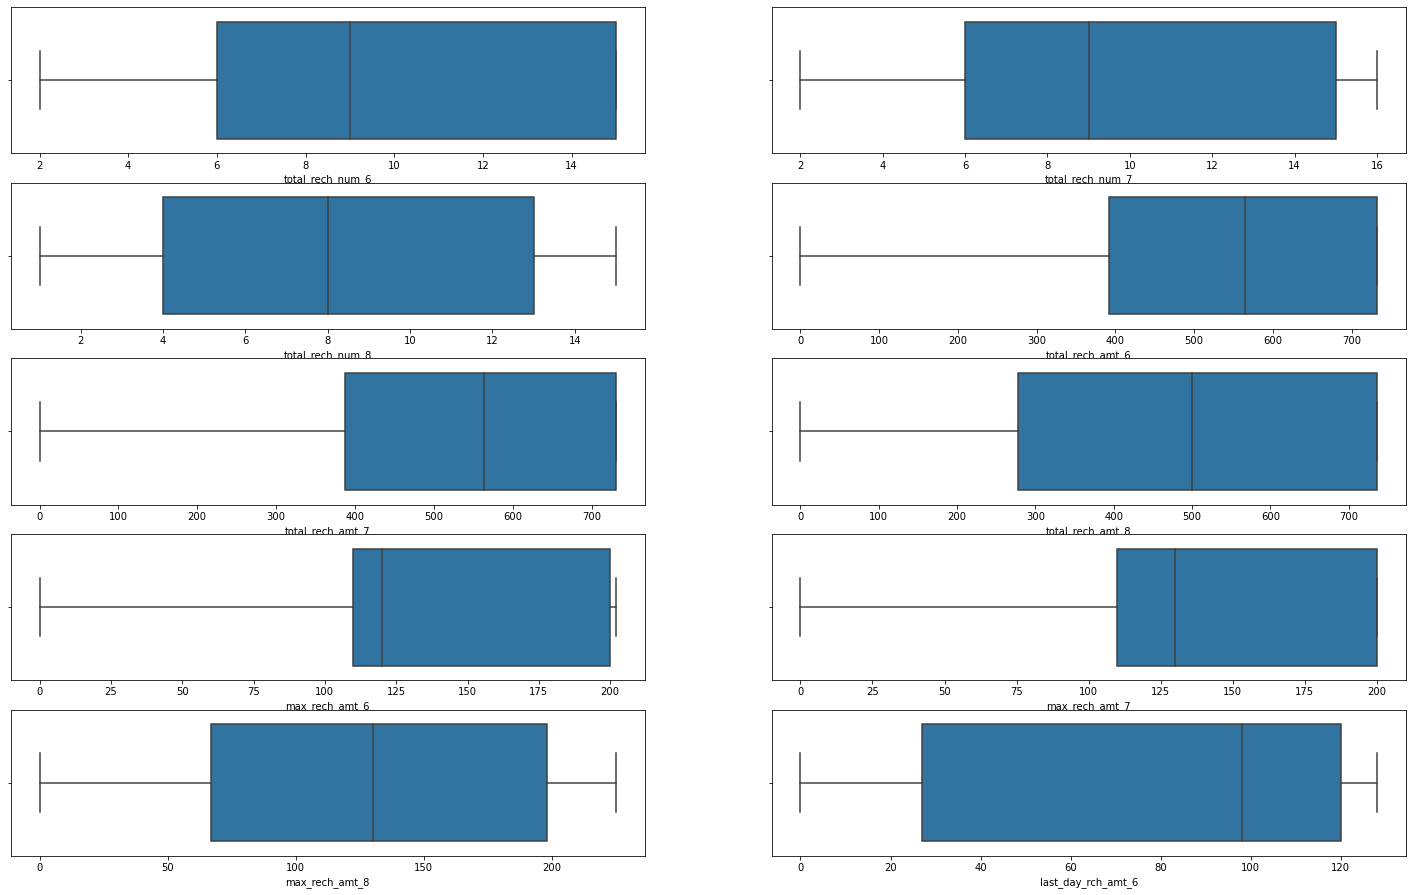

In [42]:
uni_cont(rech[:10])

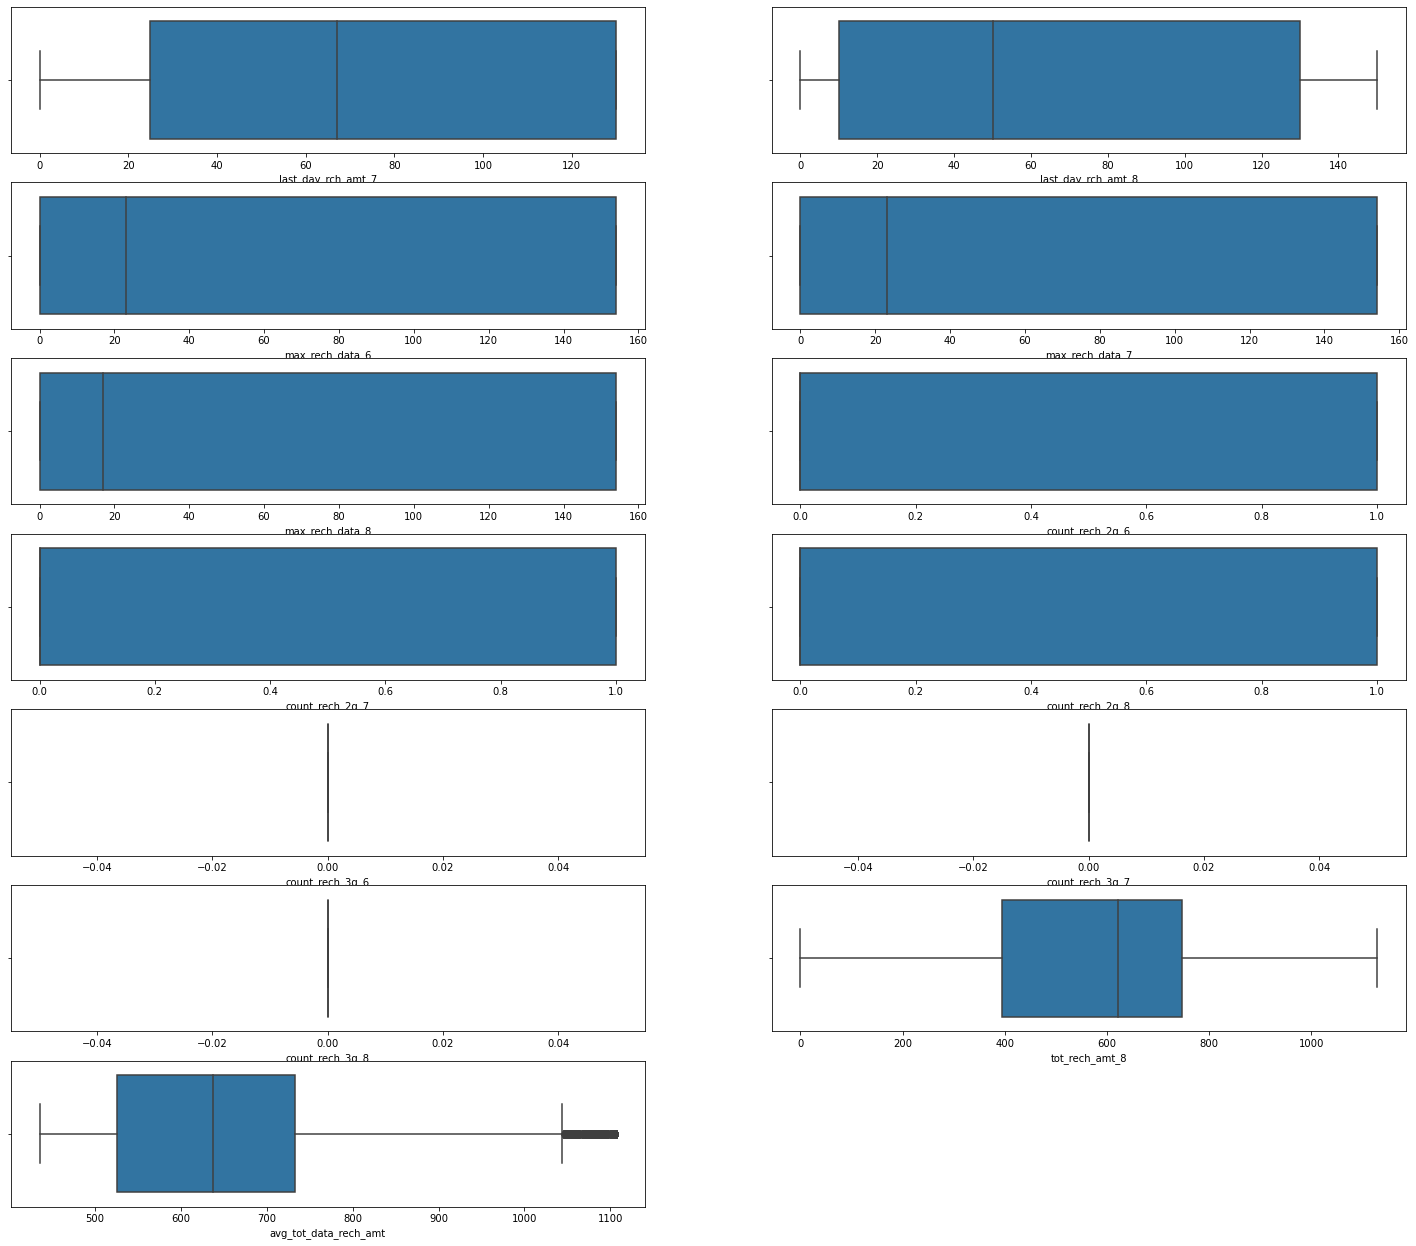

In [43]:
uni_cont(rech[10:])

1. total_rech_num, total_rech_amt: The features follow a similar trend in June and July but there is a slight drop in August. There are no outliers in the data.
2. max_rech_amt: The features follow a similar trend across June-Aug. There are no outliers in the data.
3. last_day_rch_amt: The features do not follow similar trend across Jun-Aug, the amount drops from June till August.
4. max_rech_data: The features follow a similar trend across June-Aug. There are no outliers in the data.
5. count_rech_2g: The median is 0 across all months and there is a lack of variance, therefore these features can be dropped.
6. count_rech_2g: There is only one value, 0, across all months and there is a lack of variance, therefore these features can be dropped.
7. tot_rech_amt_8: There are no outliers in the data and the data is quite varied. 
8. avg_tot_data_rech_amt: There are no outliers in the data and the data is quite varied.

<b>Average Revenue Per User features (ARPU)</b>

In [44]:
arpu = [i for i in tele.columns if 'arpu' in i]

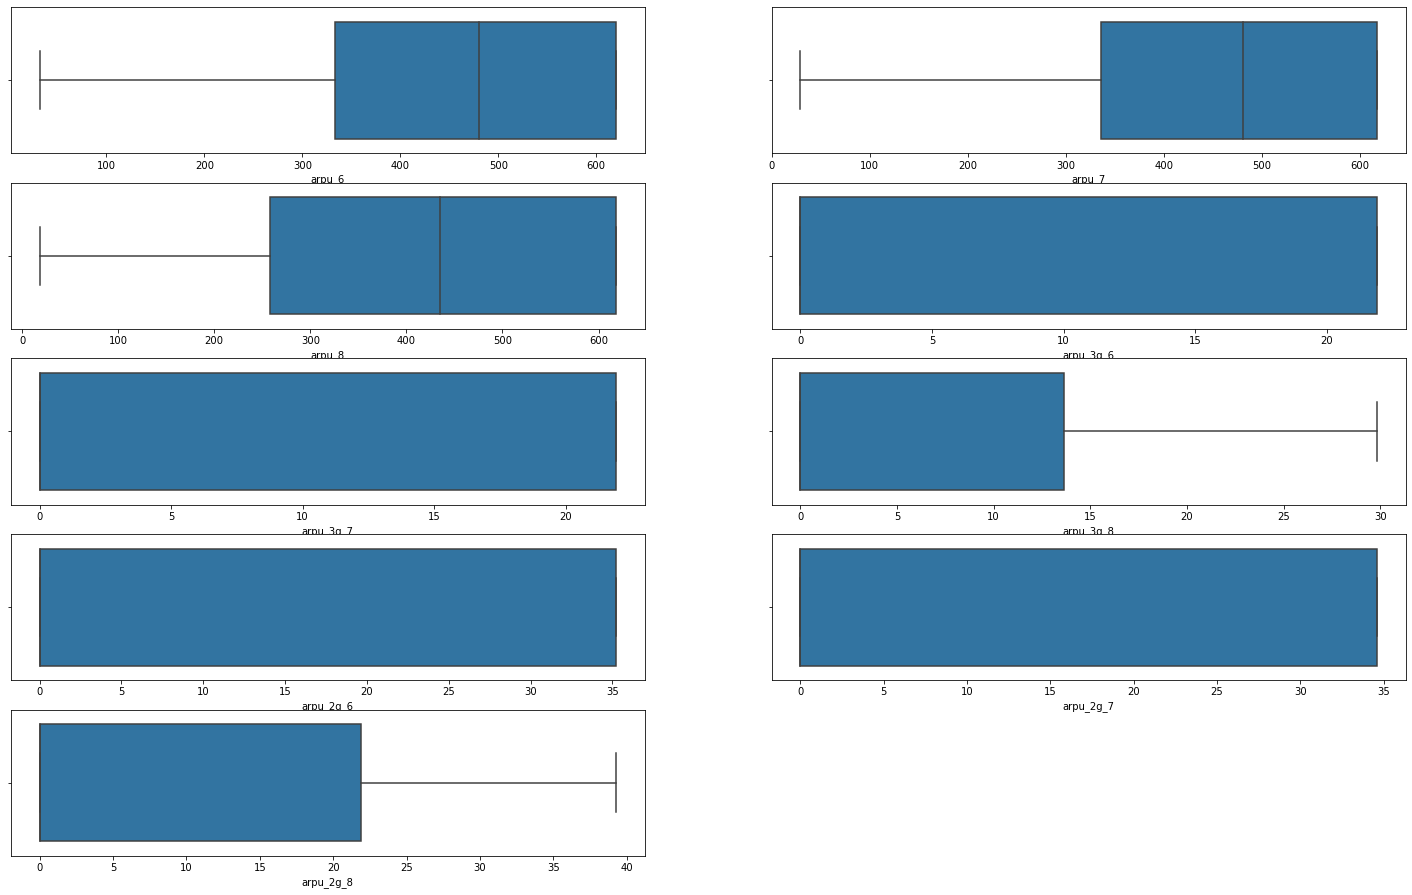

In [45]:
uni_cont(arpu)

1. None of these features have outliers. 
2. Across months June-August, the range of avg. rev. per user is around the same. 
3. For the 2g and 3g variables, the min - median values are 0 indicating that these features do not contain enough information to predict the target variable. (These may be dropped)

#### Incoming Calls

In [46]:
ic = [i for i in tele.columns if 'ic' in i]

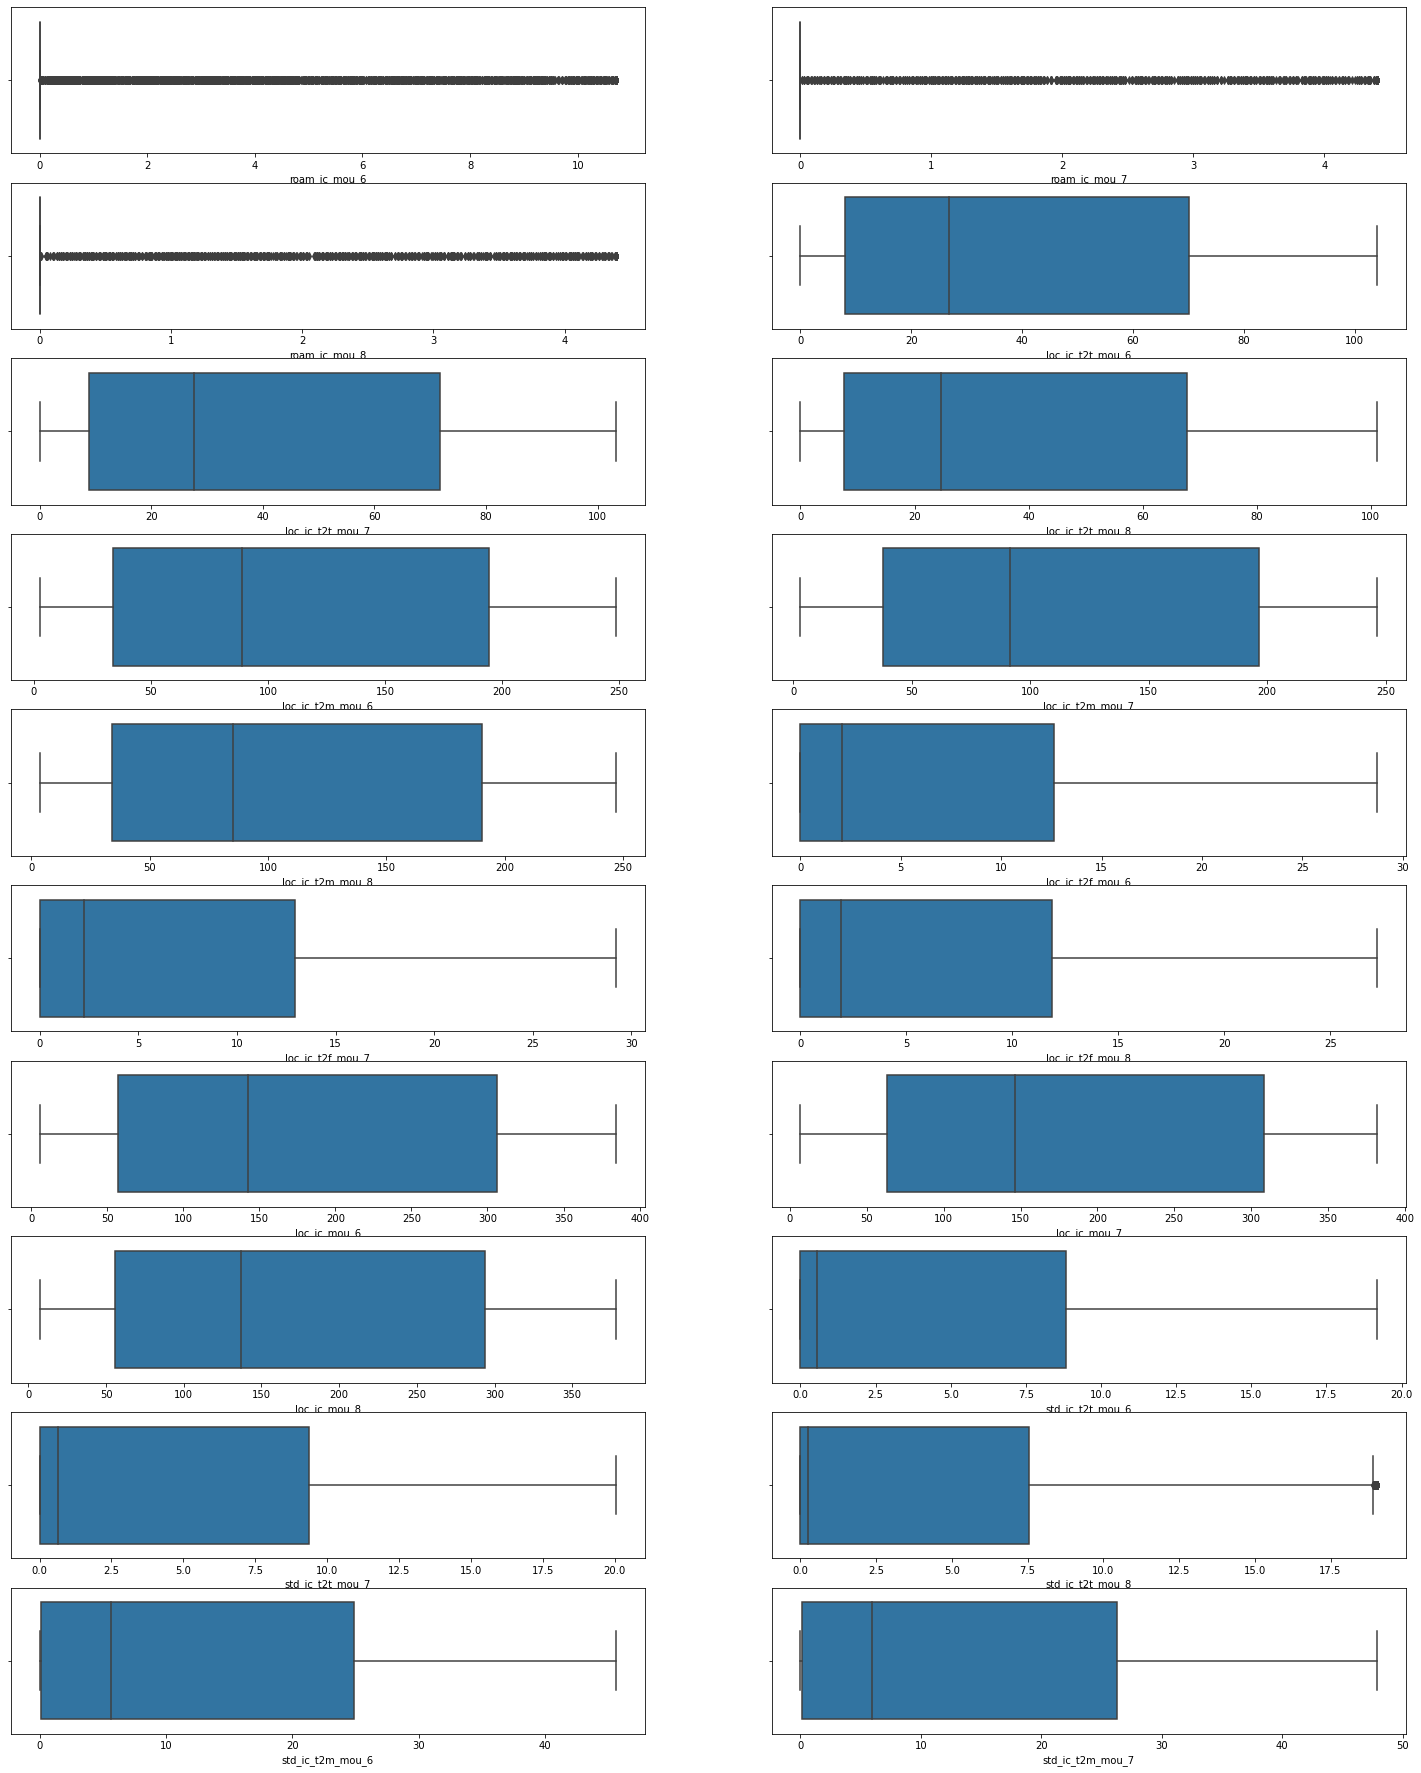

In [47]:
uni_cont(ic[:round(len(ic)/2)])

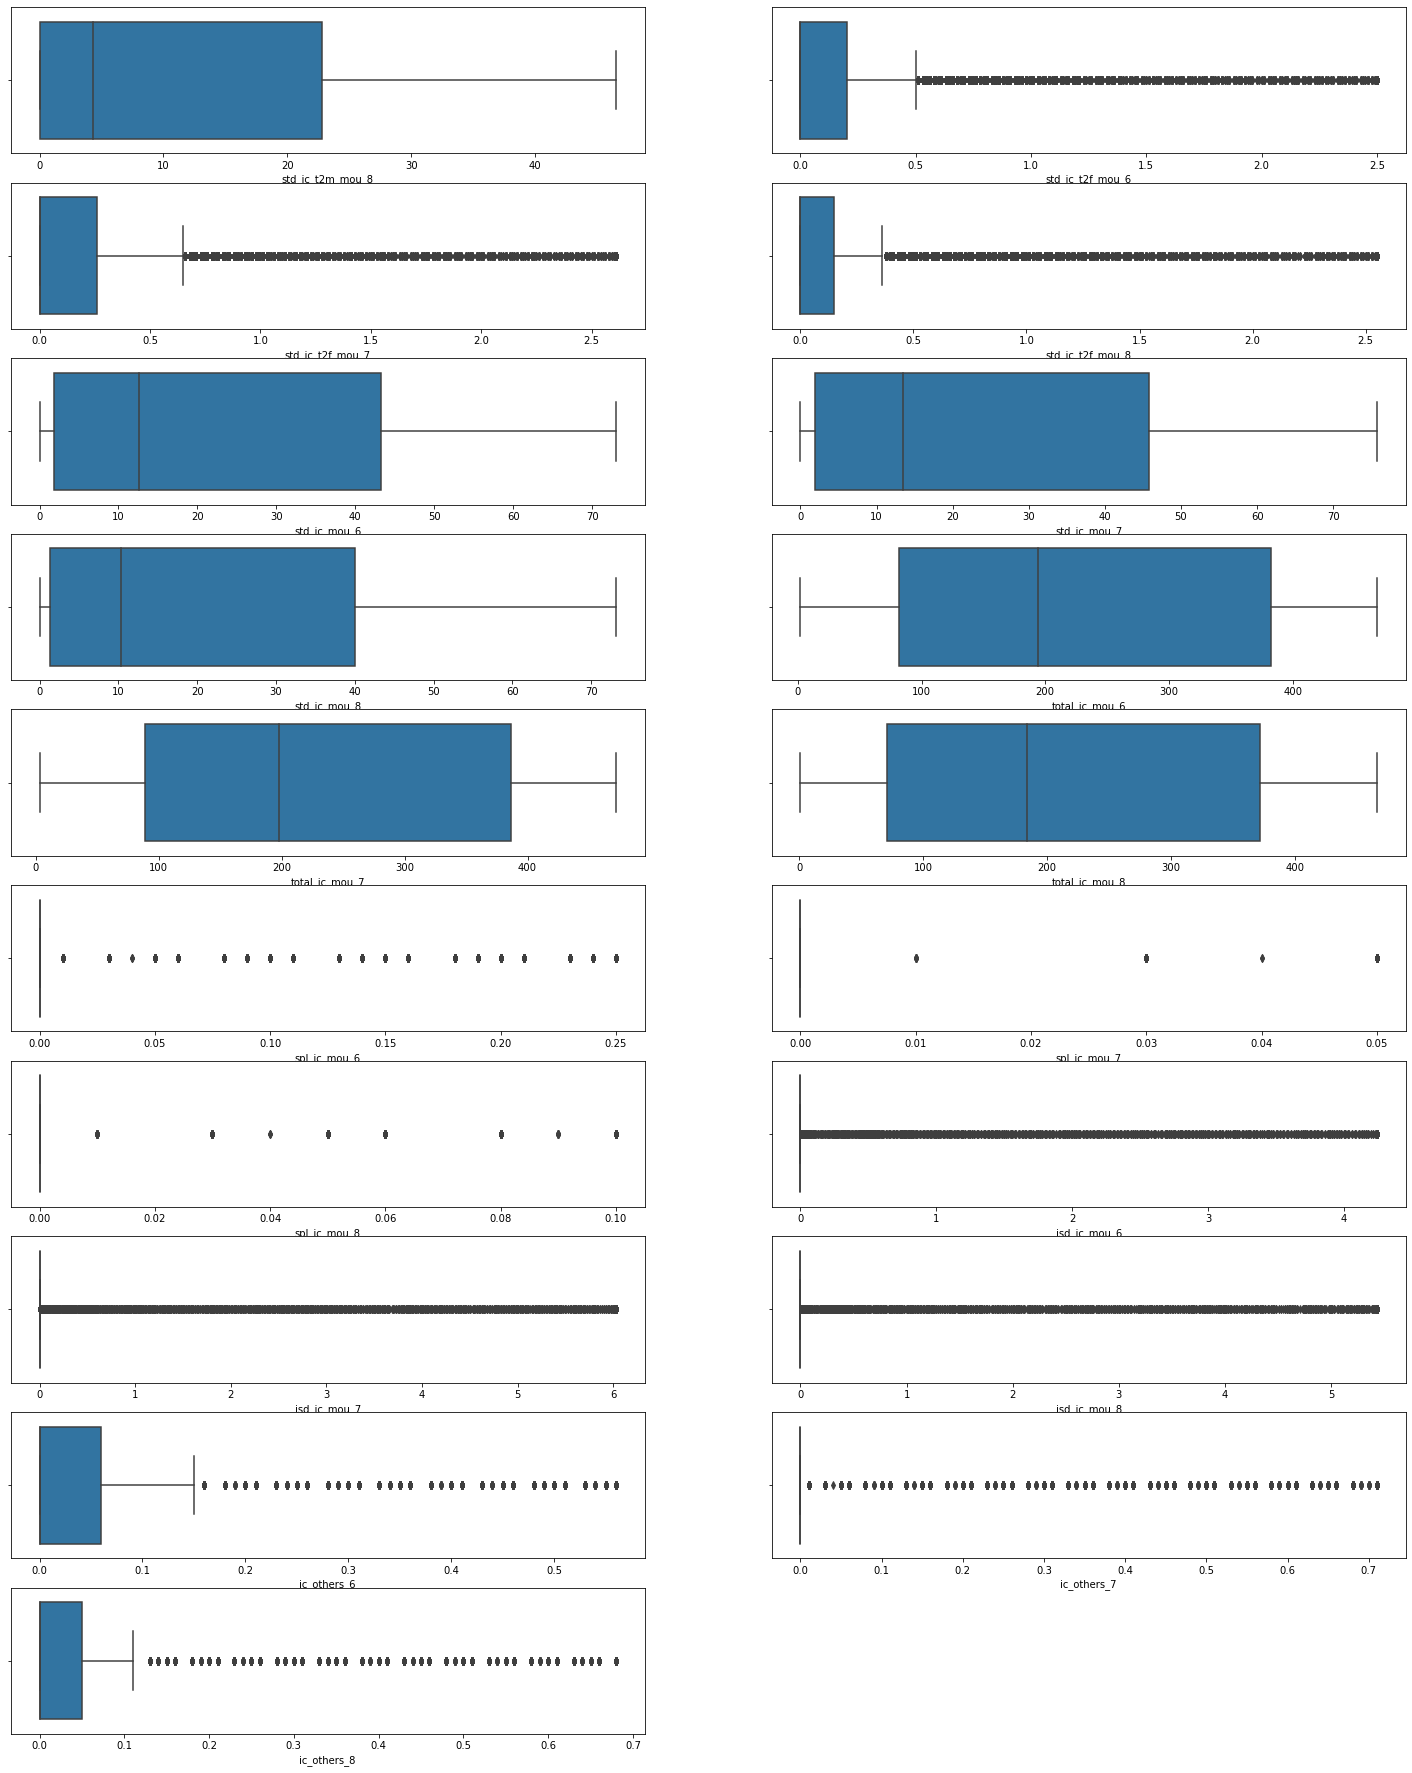

In [48]:
uni_cont(ic[round(len(ic)/2):])

1. Roaming - Most of the values (LQR to UQR) in the 'roam' features are 0 and the remaining are outliers indicating that these features do not contain enough information to predict the target variable. (These may be dropped)
2. Local calls (t2t)- These features do not have outliers, they are within the range 0-100 min. approx. with median around 25 and they follow same trend across months Jun-Aug.
3. Local calls (t2m)- These features do not have outliers, they are within the range 0-250 min. approx. with median around 85-90 and they follow same trend across months Jun-Aug.
4. Local calls (t2f)- These features do not have outliers, they are within the range 0-29 min. approx. with median around 2 and they follow same trend across months Jun-Aug.
5. Local calls - These features do not have outliers, they are within the range 0-385 min. approx. with median around 140 and they follow same trend across months Jun-Aug.
6. STD calls - These features do not have outliers, they are within the range 0-75 min. approx. with median around 11 and they follow same trend across months Jun-Aug.
7.  Total incoming - These features do not have outliers, they are within the range 0-450 min. approx. with median around 190 and they follow same trend across months Jun-Aug.
8. STD (t2f), spl, ISD, others - These features have outliers, with median 0 and they follow same trend across months Jun-Aug. Since there is very less variance in the values of each of these variables, they do not give much information and therefore can be dropped.

#### Outgoing calls

In [49]:
og = [i for i in tele.columns if 'og' in i]

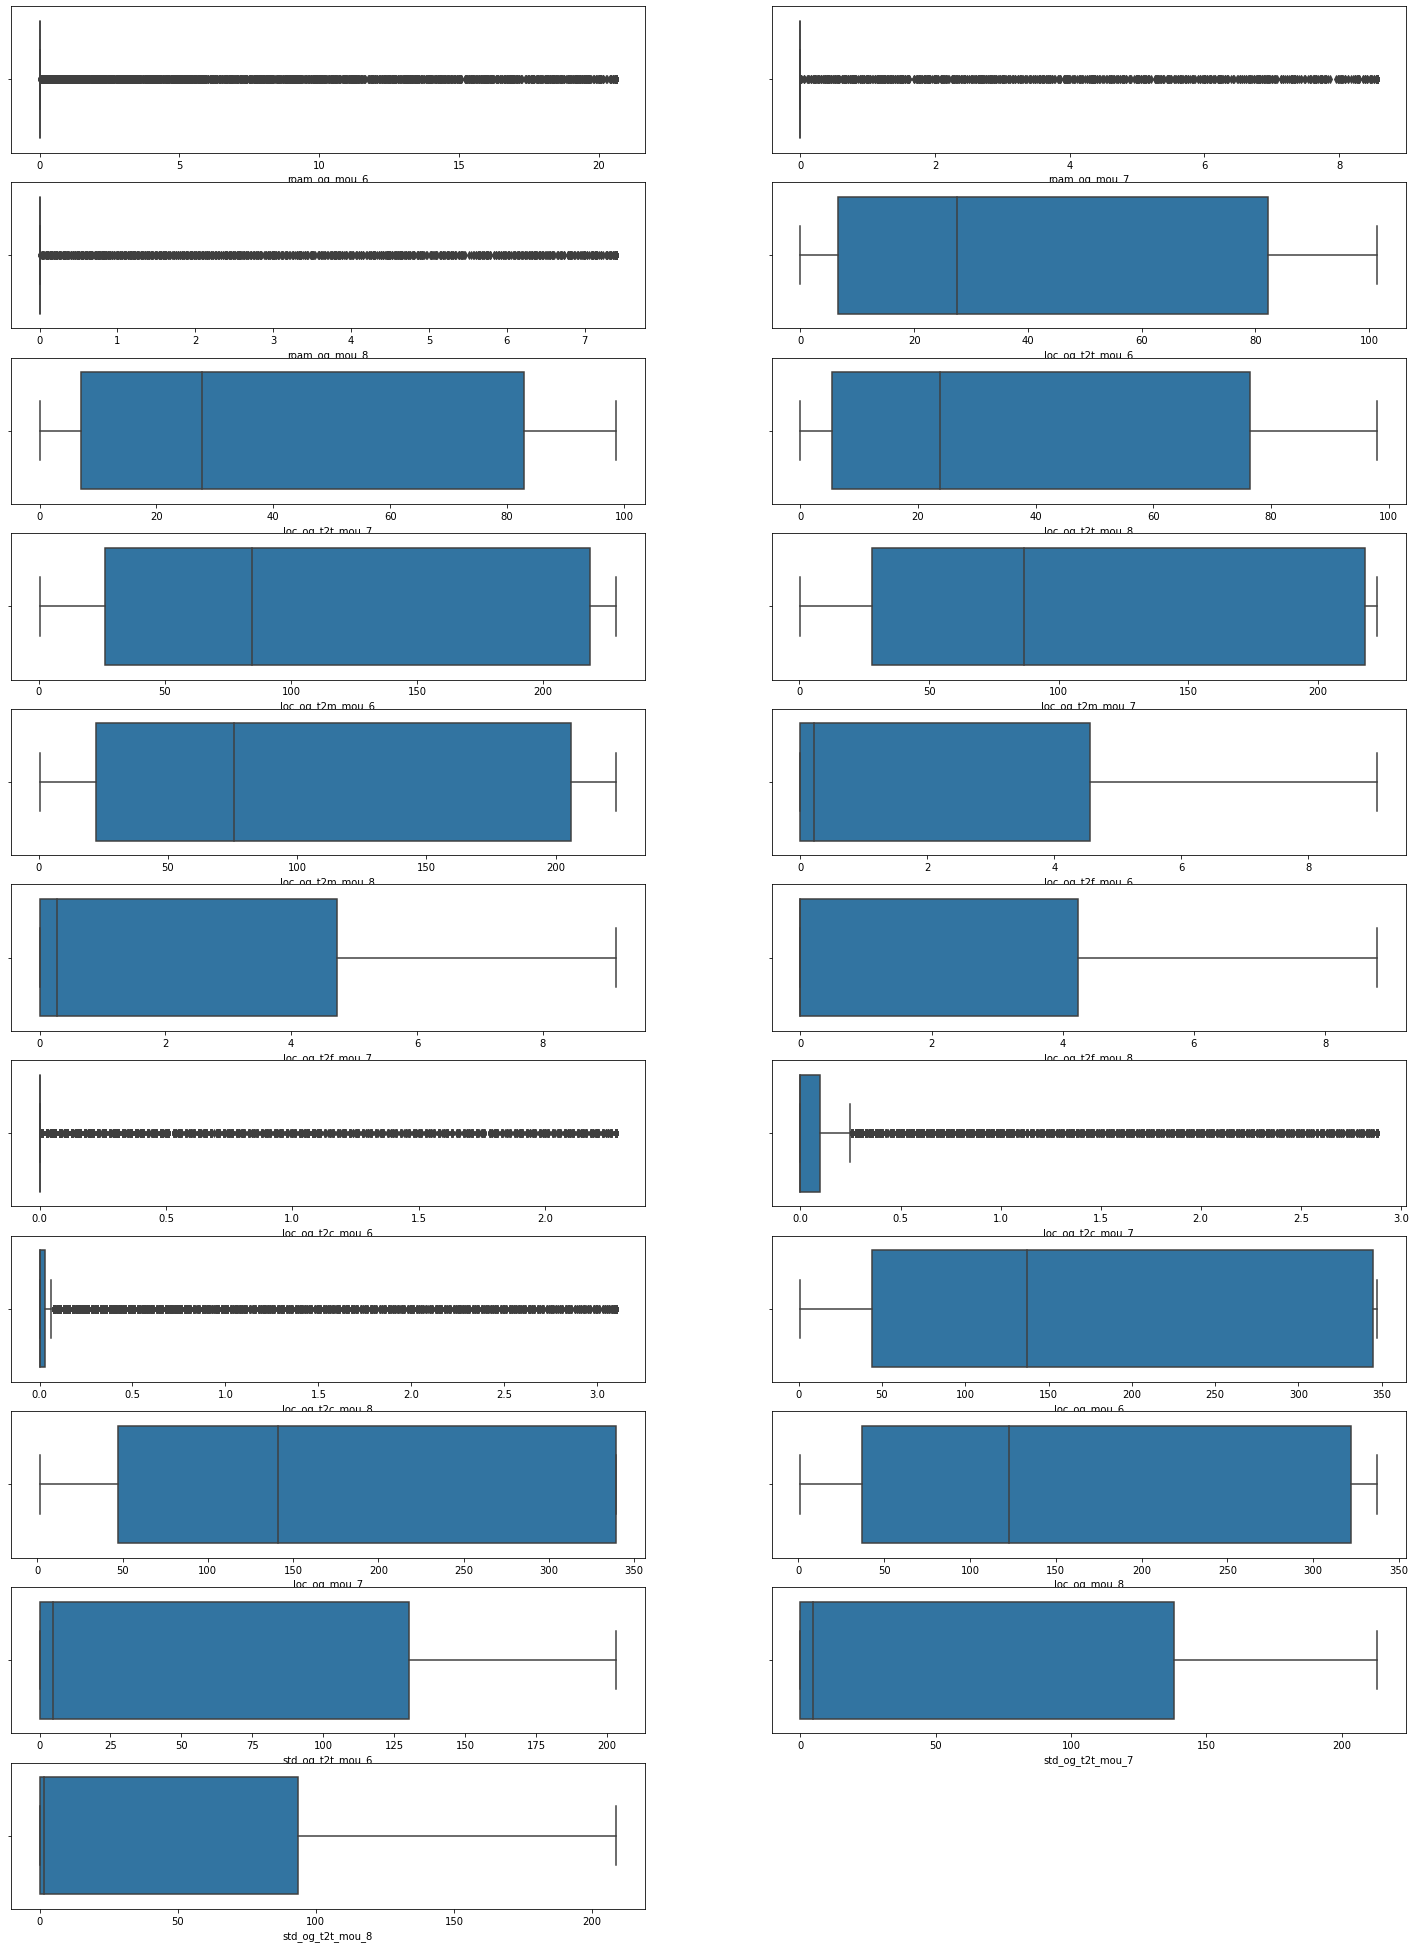

In [50]:
uni_cont(og[:round(len(og)/2)])

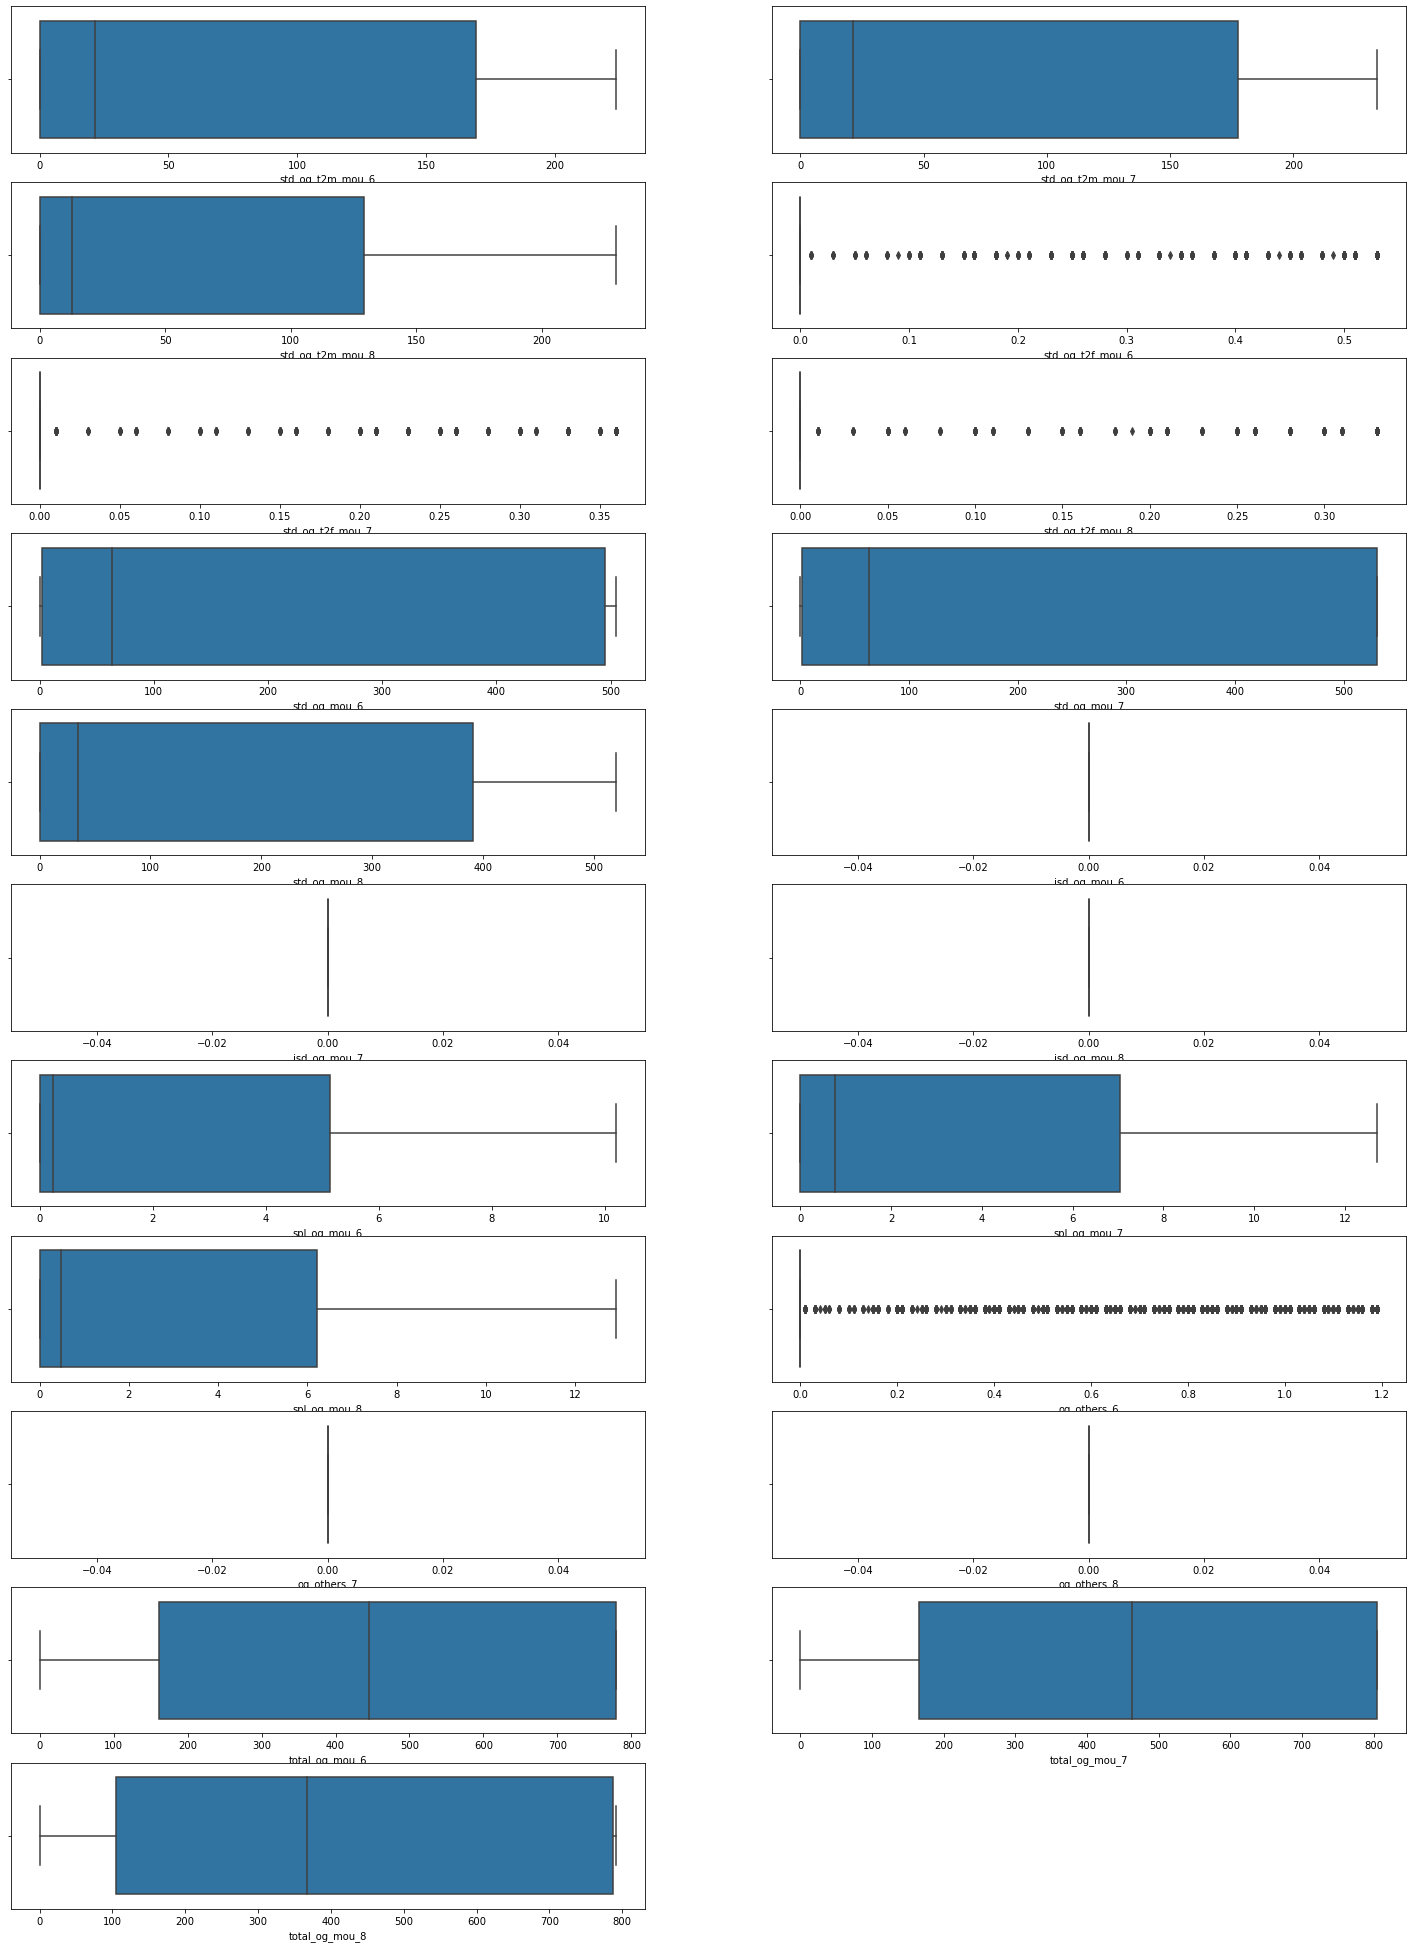

In [51]:
uni_cont(og[round(len(og)/2):])

1. Roaming - Most of the values (LQR to UQR) in the 'roam' features are 0 and the remaining are outliers indicating that these features do not contain enough information to predict the target variable. (These may be dropped)
2. Local calls (t2t)- These features do not have outliers, they are within the range 0-100 min. approx. with median around 25 and they follow same trend across months Jun-Aug.
3. Local calls (t2m)- These features do not have outliers, they are within the range 0-230 min. approx. with median around 85-90 and they follow same trend across months Jun-Aug.
4. Local calls (t2f)- These features do not have outliers, they are within the range 0-9 min. approx. with median around 0 and they follow same trend across months Jun-Aug.
5. Local calls (t2c)- These features have outliers, with median 0 and they follow same trend across months Jun-Aug. Since there is very less variance in the values of each of these variables, they do not give much information and therefore can be dropped.
6. Local calls - These features do not have outliers, they are within the range 0-350 min. approx. with median around 120-142 and they follow same trend across months Jun-Aug.
7. STD calls (t2t) - These features have outliers, they are within the range 0-215 min. approx. with median around 1-5 and they follow similar trend across months Jun-Aug. Althouhg not visible in the boxplots, these features have median around 5 and mean around 60 indicating presence of outliers.
8. STD calls (t2m) - These features have outliers, they are within the range 0-235 min. approx. with median around 12-22 and they follow similar trend across months Jun and July but we see a slight drop in August. Althouhg not visible in the boxplots, these features have median around in the range 12-22 and mean in the range of 65-80 indicating presence of outliers.
9. STD calls - These features do not have outliers, they are within the range 0-500 min. approx. with median around 63 for June and July,  but we see a slight drop in August with median value around 34.
10. spl - These features do not have outliers, they are within the range 0-13 min. approx. with median less than 1 and they follow similar trend across months Jun-Aug. Since there is very less variance in the values of each of these variables, they do not give much information and therefore can be dropped.
11.  Total outgoing - These features do not have outliers, they are within the range 0-800 min. approx. with median around 450 for June and July,  but we see a drop in August with median value around 360.
12. STD (t2f), ISD, others - These features have outliers, with median 0 and they follow same trend across months Jun-Aug. Since there is very less variance in the values of each of these variables, they do not give much information and therefore can be dropped.

#### Monthly and Sachet (Schemes with validity <= 1 month )

In [52]:
ms = [i for i in tele.columns if (('monthly' in i)|('sachet' in i))]

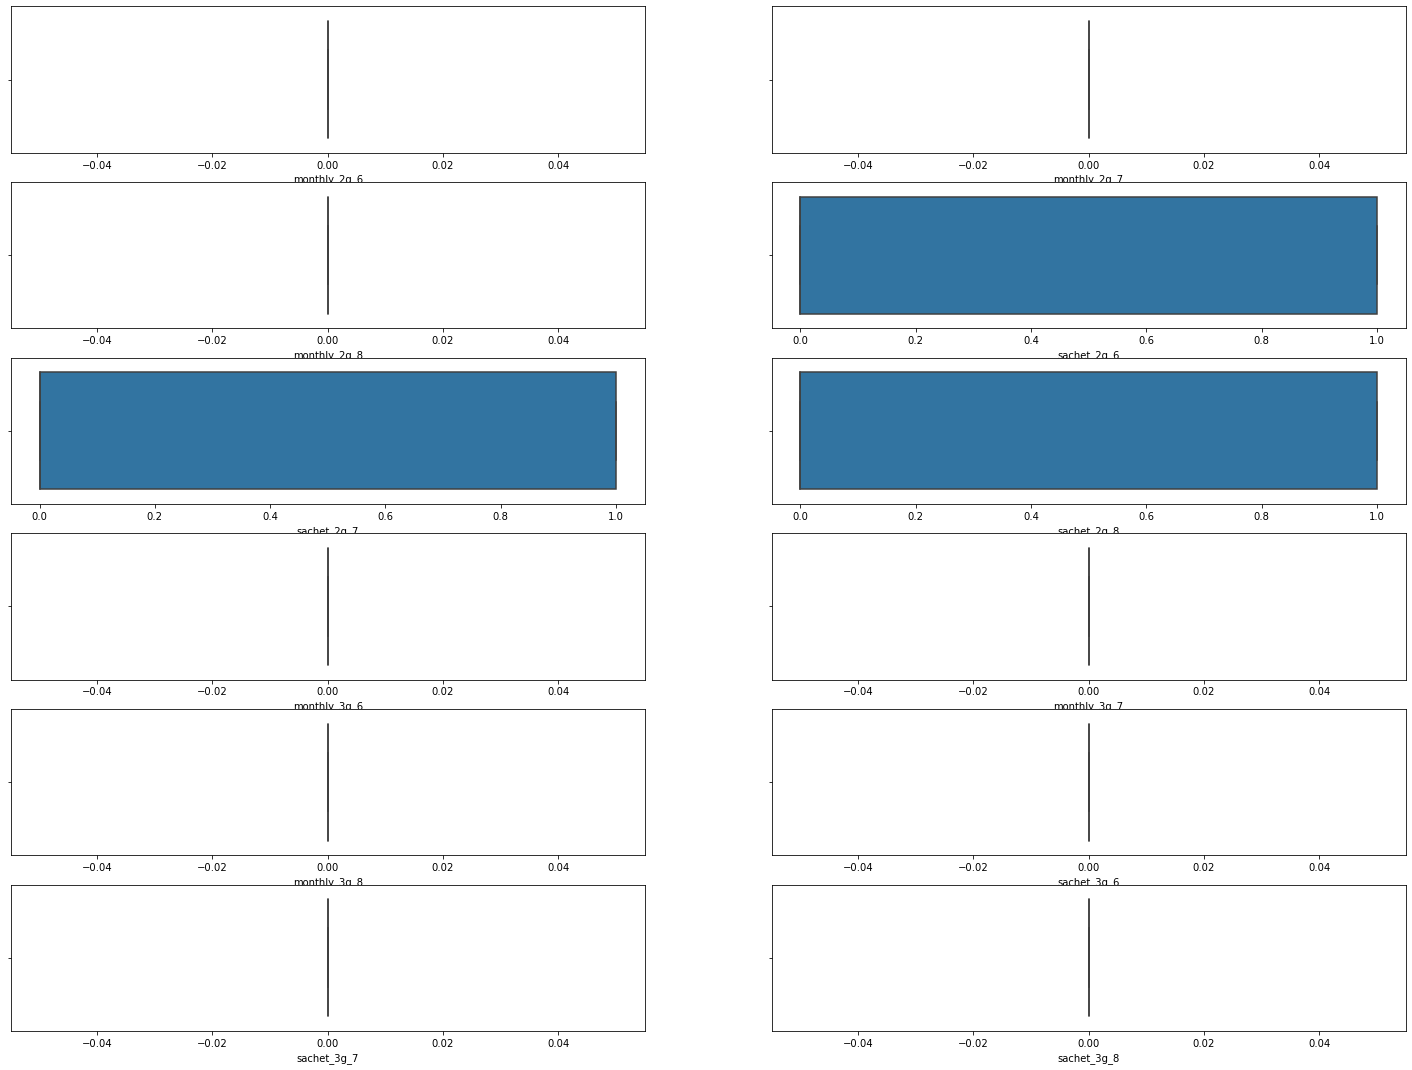

In [53]:
uni_cont(ms)

1. For the features monthly and sachet_3g, all values are 0 and thus these can be dropped.
2. For sachet_2g, values are between 0 and 1 for Jun-Aug with median 0, indicating low variance. Therefore these can be dropped. 

#### Volume, VBC

In [54]:
vv = [i for i in tele.columns if (('vol' in i)|('vbc' in i))]

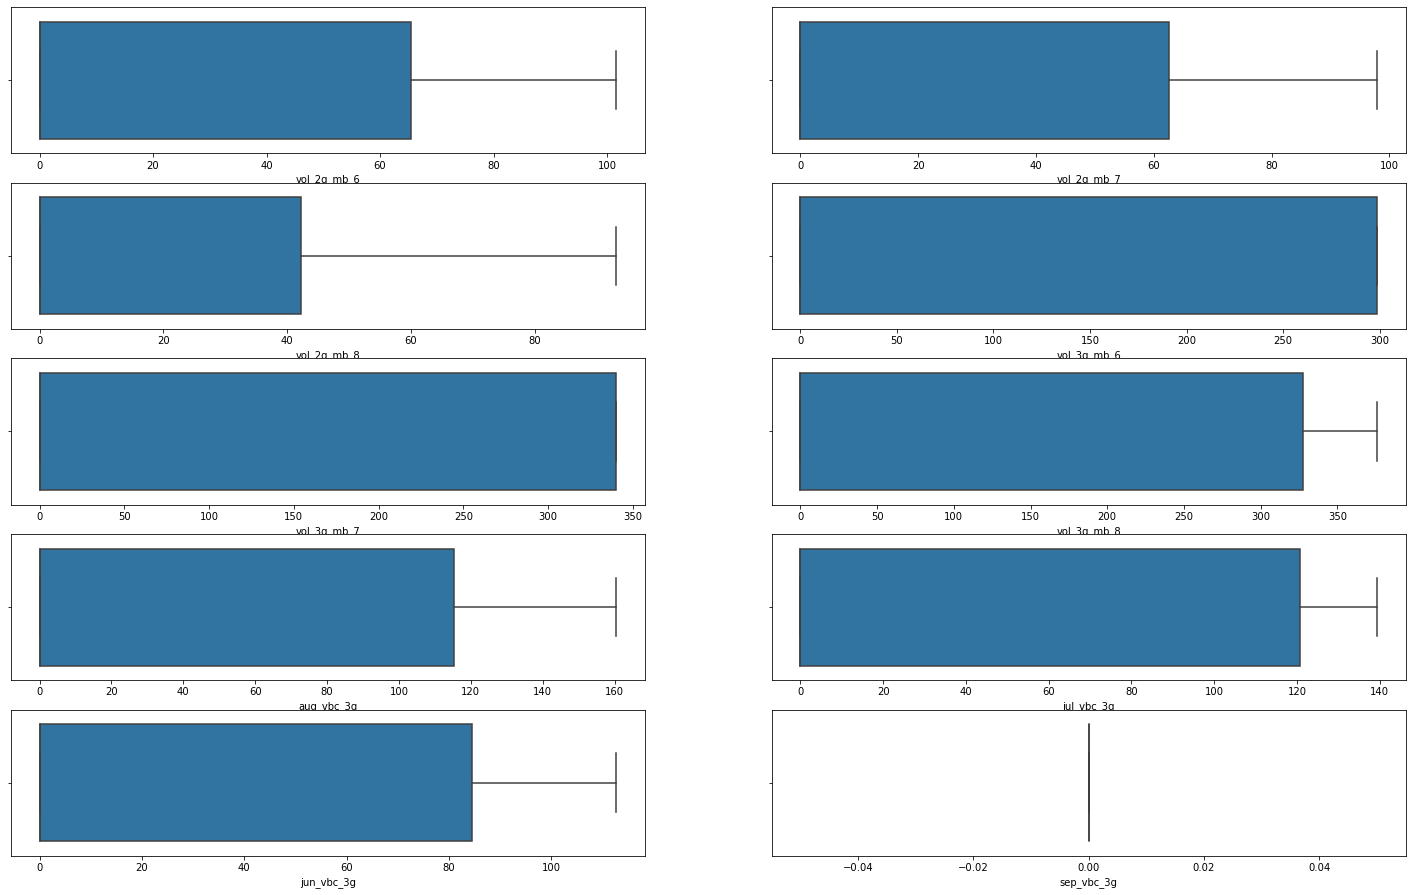

In [55]:
uni_cont(vv)

- These features have median 0 for Jun-Aug indicating low variance. Therefore these may be dropped. 

#### Onnet, Offnet and AON

In [56]:
ooa = [i for i in tele.columns if (('onnet' in i)|('offnet' in i)|('aon' in i))]

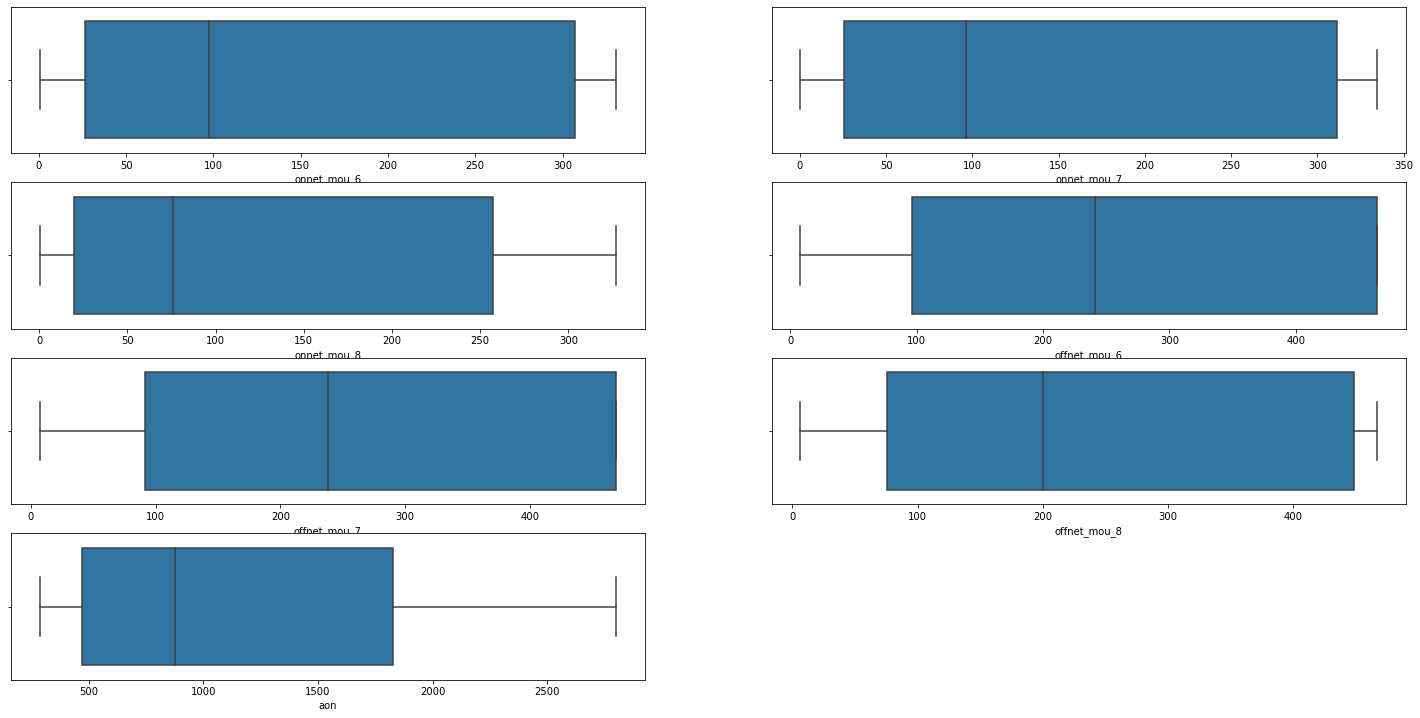

In [57]:
uni_cont(ooa)

1. Onnet - For months June and July, the values follow a similar trend with range around 0-335 and median around 97. However for the month of August, there is a dip, i.e., range around 0-327 and median around 75.
2. Offnet - For months June and July, the values follow a similar trend with range around 6-470 and median around 240. However for the month of August, there is a dip, i.e., median around 200.
3. aon - The range ois 286-2800 with median 876.

#### Categorical

- The bar_plots function has been defined to show the frequency of categories for each categorical variable given in the list (input list of categorical variables).

In [58]:
def bar_plots(cat_cols,df=tele):
    plt.figure(figsize=(20,30))
    for i in range(0,len(cat_cols)):
        plt.subplot(7,2,i+1)  
        plt.title(cat_cols[i])
        df[cat_cols[i]].value_counts().plot.bar()
plt.show()

In [59]:
cat = [i for i in tele.columns if (('pck' in i)|('fb' in i))]
cat

['night_pck_user_6',
 'night_pck_user_7',
 'night_pck_user_8',
 'fb_user_6',
 'fb_user_7',
 'fb_user_8']

#### Night pack and FB user

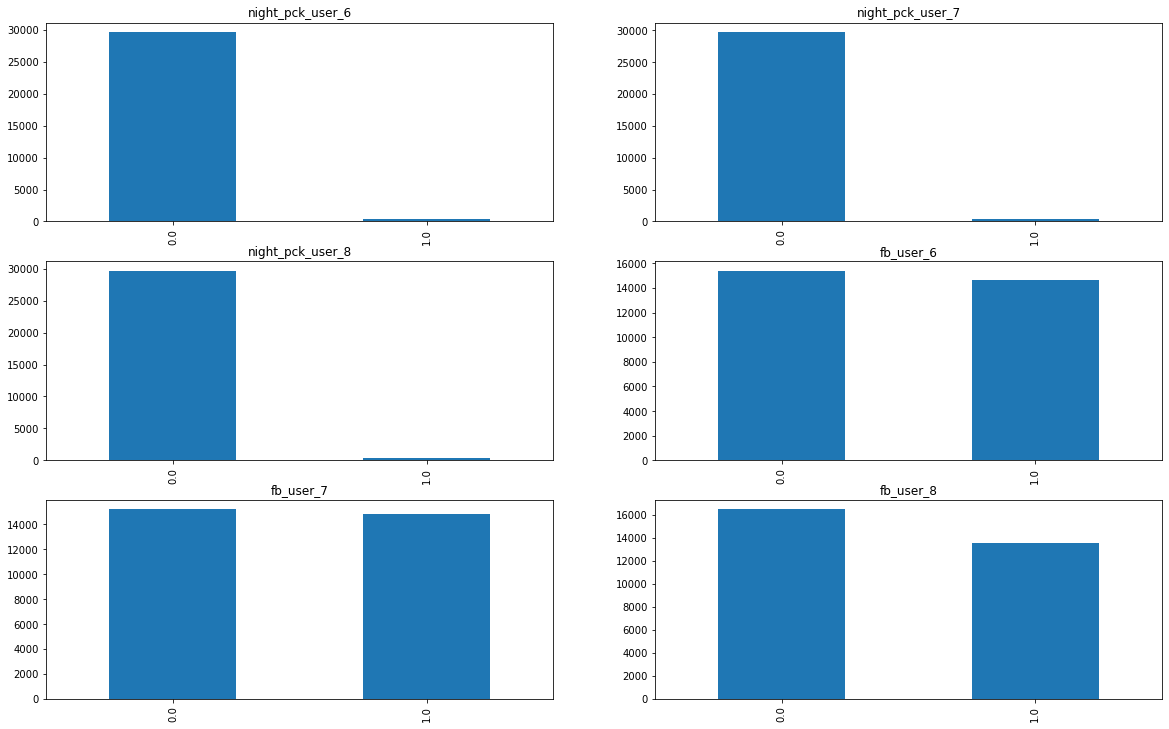

In [60]:
bar_plots(cat)

1. night_pck_user - These features have high class imbalance. 
2. fb_user - These features have class balance with a small difference between class 1 and 0 across months Jun-Aug.

In [61]:
tele=tele.drop([i for i in tele.columns if 'pck' in i],axis=1)

### Dropping features with min var

- Features with minimum variance in their values are being dropped as they will most likely not contribute to the prediction of the target variable due to lack of information.
- Minimum variance features are being identifed by checking the difference between the 75th and 25th percentiles. If the difference is small, it indicates that the 75th and 25th percentiles are close in value, i.e., at least 50% of the data is similar/lacks variability.
- If there are variables that are not identified by the logic mentioned above, PCA will be performed later and in case they lack variability according to the PCA algorithm, they will be dropped.

In [62]:
o=tele.select_dtypes(include=['float64','int64']).columns

In [63]:
drop_list = [i for i in o if abs(tele[i].describe()['75%']-tele[i].describe()['25%'])<10]
drop_list

['roam_ic_mou_6',
 'roam_ic_mou_7',
 'roam_ic_mou_8',
 'roam_og_mou_6',
 'roam_og_mou_7',
 'roam_og_mou_8',
 'loc_og_t2f_mou_6',
 'loc_og_t2f_mou_7',
 'loc_og_t2f_mou_8',
 'loc_og_t2c_mou_6',
 'loc_og_t2c_mou_7',
 'loc_og_t2c_mou_8',
 'std_og_t2f_mou_6',
 'std_og_t2f_mou_7',
 'std_og_t2f_mou_8',
 'isd_og_mou_6',
 'isd_og_mou_7',
 'isd_og_mou_8',
 'spl_og_mou_6',
 'spl_og_mou_7',
 'spl_og_mou_8',
 'og_others_6',
 'og_others_7',
 'og_others_8',
 'std_ic_t2t_mou_6',
 'std_ic_t2t_mou_7',
 'std_ic_t2t_mou_8',
 'std_ic_t2f_mou_6',
 'std_ic_t2f_mou_7',
 'std_ic_t2f_mou_8',
 'spl_ic_mou_6',
 'spl_ic_mou_7',
 'spl_ic_mou_8',
 'isd_ic_mou_6',
 'isd_ic_mou_7',
 'isd_ic_mou_8',
 'ic_others_6',
 'ic_others_7',
 'ic_others_8',
 'total_rech_num_6',
 'total_rech_num_7',
 'total_rech_num_8',
 'count_rech_2g_6',
 'count_rech_2g_7',
 'count_rech_2g_8',
 'count_rech_3g_6',
 'count_rech_3g_7',
 'count_rech_3g_8',
 'monthly_2g_6',
 'monthly_2g_7',
 'monthly_2g_8',
 'sachet_2g_6',
 'sachet_2g_7',
 'sachet_2g

In [64]:
#Checking distribution of the variables about to be dropped
tele[drop_list].describe()

,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,...,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,sep_vbc_3g
count,30019.000000,30019.000000,30019.000000,30019.000000,30019.000000,30019.000000,30019.000000,30019.000000,30019.000000,30019.000000,...,30019.000000,30019.000000,30019.000000,30019.0,30019.0,30019.0,30019.0,30019.0,30019.0,30019.0
mean,1.823755,0.675178,0.706722,3.518189,1.331635,1.186942,2.522301,2.571640,2.372899,0.416294,...,0.258403,0.266065,0.262467,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,3.860963,1.551615,1.576377,7.453137,3.043898,2.660718,3.513213,3.549222,3.378754,0.832252,...,0.437764,0.441906,0.439982,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.210000,0.280000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.560000,4.730000,4.230000,0.000000,...,1.000000,1.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,10.710000,4.400000,4.390000,20.610000,8.560000,7.402000,9.080000,9.164000,8.790000,2.280000,...,1.000000,1.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [65]:
tele=tele.drop(drop_list,axis=1)

In [66]:
#Checking number of columns remaining
tele.shape

(30019, 95)

#### Date columns

In [67]:
dates = [i for i in tele.columns if 'date' in i]

In [68]:
#Data Exploration for Date columns
tele[dates].head(10)

,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8
0,6/30/2014,7/31/2014,8/31/2014,6/21/2014,7/16/2014,8/8/2014,6/21/2014,7/16/2014,8/8/2014
1,6/30/2014,7/31/2014,8/31/2014,6/27/2014,7/25/2014,8/26/2014,0,0,0
2,6/30/2014,7/31/2014,8/31/2014,6/25/2014,7/31/2014,8/30/2014,0,7/31/2014,8/23/2014
3,6/30/2014,7/31/2014,8/31/2014,6/30/2014,7/31/2014,8/14/2014,0,0,0
4,6/30/2014,7/31/2014,8/31/2014,6/30/2014,7/31/2014,8/31/2014,0,0,0
5,6/30/2014,7/31/2014,8/31/2014,6/30/2014,7/30/2014,8/26/2014,6/30/2014,7/28/2014,8/26/2014
6,6/30/2014,7/31/2014,8/31/2014,6/30/2014,7/28/2014,8/24/2014,0,0,0
7,6/30/2014,7/31/2014,8/31/2014,6/24/2014,7/22/2014,8/31/2014,0,0,0
8,6/30/2014,7/31/2014,8/31/2014,6/29/2014,7/23/2014,8/28/2014,0,0,0
9,6/30/2014,7/31/2014,8/31/2014,6/29/2014,7/31/2014,8/26/2014,6/29/2014,7/26/2014,8/2/2014


In [69]:
tele[['date_of_last_rech_data_6','date_of_last_rech_data_7','date_of_last_rech_data_8']]=tele[['date_of_last_rech_data_6','date_of_last_rech_data_7','date_of_last_rech_data_8']].astype(str)

In [70]:
#Preprocessing step 1: Replacing 0 with 1st of the month for earliest month and previous month value for consective months 
tele['date_of_last_rech_data_6']=tele['date_of_last_rech_data_6'].replace('0','6/1/2014')
tele['date_of_last_rech_data_7']=np.where(tele['date_of_last_rech_data_7']=='0',tele['date_of_last_rech_data_6'],tele['date_of_last_rech_data_7'])
tele['date_of_last_rech_data_8']=np.where(tele['date_of_last_rech_data_8']=='0',tele['date_of_last_rech_data_7'],tele['date_of_last_rech_data_8'])

In [71]:
#Preprocessing step 2: Converting to datetime variables
tele[['last_date_of_month_8','date_of_last_rech_8','date_of_last_rech_data_8']]=tele[['last_date_of_month_8','date_of_last_rech_8','date_of_last_rech_data_8']].apply(lambda x:pd.to_datetime(x,format='%m/%d/%Y').dt.date)

In [72]:
#Preprocessing step 3: Getting numbers of days since last recharge and converting to int for modelling purpose
tele['days_last_rech']=(tele['last_date_of_month_8']-tele['date_of_last_rech_8']).dt.days
tele['days_last_rech_data']=(tele['last_date_of_month_8']-tele['date_of_last_rech_data_8']).dt.days

In [73]:
#EDA
tele[['days_last_rech','days_last_rech_data']].describe()

,days_last_rech,days_last_rech_data
count,30019.000000,30019.000000
mean,4.778740,44.290982
std,6.920059,37.416228
min,0.000000,0.000000
25%,1.000000,9.000000
50%,3.000000,29.000000
75%,6.000000,91.000000
max,80.000000,91.000000


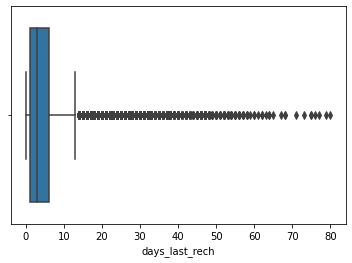

In [74]:
sns.boxplot(tele['days_last_rech'])
plt.show()

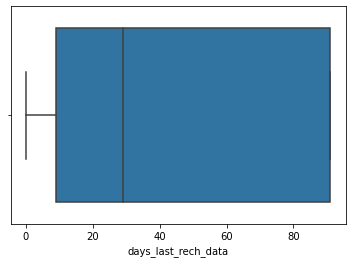

In [75]:
sns.boxplot(tele['days_last_rech_data'])
plt.show()

1. days_last_rech: There are outliers in the data with a low median.
2. days_last_rech_data: Values are in the range 0-100 with median around 30.

In [76]:
#Dropping date variables as new 'days' features were derived from these
tele=tele.drop(dates,axis=1)

In [77]:
#Checking number of remaining columns
tele.shape

(30019, 88)

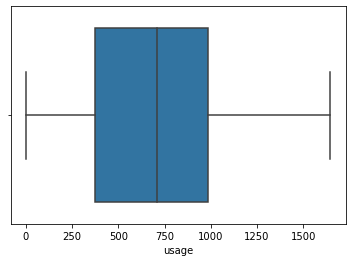

In [78]:
#EDA for usage variable
sns.boxplot(tele['usage'])
plt.show()

- The values of the usage variable range from 0-1600 approx. with a median around 700. There seem to be no outliers.

### Exploring target variable

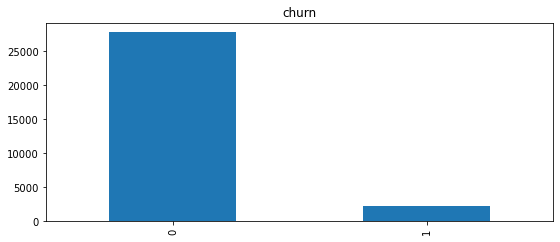

In [79]:
bar_plots(['churn'])

In [80]:
#Distribution of target variable across classes 0 (NOT CHURN) and 1 (CHURN)
str(round((pd.value_counts(tele['churn'])/len(tele))*100,2)[0])+' % falls under class 0, "Not Churn", and '+str(round((pd.value_counts(tele['churn'])/len(tele))*100,2)[1])+' % falls under class 1, "Churn".'

'92.56 % falls under class 0, "Not Churn", and 7.44 % falls under class 1, "Churn".'

- The target variable clearly has class imbalance. This will be dealt with later on using SMOTE.

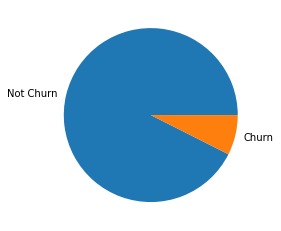

In [81]:
plt.pie(pd.value_counts(tele['churn']), labels = ['Not Churn','Churn'])
plt.show()

### Bivariate

#### Use this only for ones that seem most important
def plots(col,df=tele):
    plt.figure(figsize=(25,35))
    for i in range(0,len(col)):
            x=pd.DataFrame([np.quantile(df[col[i]],j) for j in np.arange(0.05,1,0.05)],columns=['Quantile'])
            x['Churn']=[len(df.loc[(df[col[i]]<=j)&(df['churn']==1),'churn']) for j in x['Quantile']]
            x['Not Churn']=[len(df.loc[(df[col[i]]<=j)&(df['churn']==0),'churn']) for j in x['Quantile']]

            y=pd.DataFrame()
            y[str(col)+'_bins']=[str(int(x.loc[j,'Quantile']))+'-'+str(int(x.loc[j+1,'Quantile'])) for j in range(0,len(x)-1)]
            y['Not Churn']=[x.loc[j+1,'Not Churn']-x.loc[j,'Not Churn'] for j in range(0,len(x)-1)]
            y['Churn']=[x.loc[j+1,'Churn']-x.loc[j,'Churn'] for j in range(0,len(x)-1)]
            y['Default Rate']=y['Churn']/(y['Churn']+y['Not Churn'])
            y.index=y[str(col)+'_bins']
            y=y[['Default Rate']]
            plt.subplot(11,2,i+1)
            y.plot.bar()
    plt.show()

- The cat_plots function has been defined to plot the effect of each categorical variable on the target variable, churn. It takes the list of categorical variables to be plotted, data, figure size of the plot and subplot as input and gives boxplot of each category in the variable on the y-axis and churn on the x-axis as output.

In [82]:
def cat_plots(cols,df=tele,figs=(25,35),subp_x=11,subp_y=2):
    plt.figure(figsize=figs)
    for i in range(1,len(cols)+1):
        plt.subplot(subp_x,subp_y,i)
        sns.boxplot(x = 'churn', y = cols[i-1], data = df)
    plt.show()

In [83]:
rech = [i for i in tele.columns if ((('rech' in i)|('rch' in i))&('date' not in i))]
arpu = [i for i in tele.columns if 'arpu' in i]
ic = [i for i in tele.columns if 'ic' in i]
og = [i for i in tele.columns if 'og' in i]
ms = [i for i in tele.columns if (('monthly' in i)|('sachet' in i))]
vvu = [i for i in tele.columns if (('vol' in i)|('vbc' in i))]+['usage']
ooa = [i for i in tele.columns if (('onnet' in i)|('offnet' in i)|('aon' in i))]

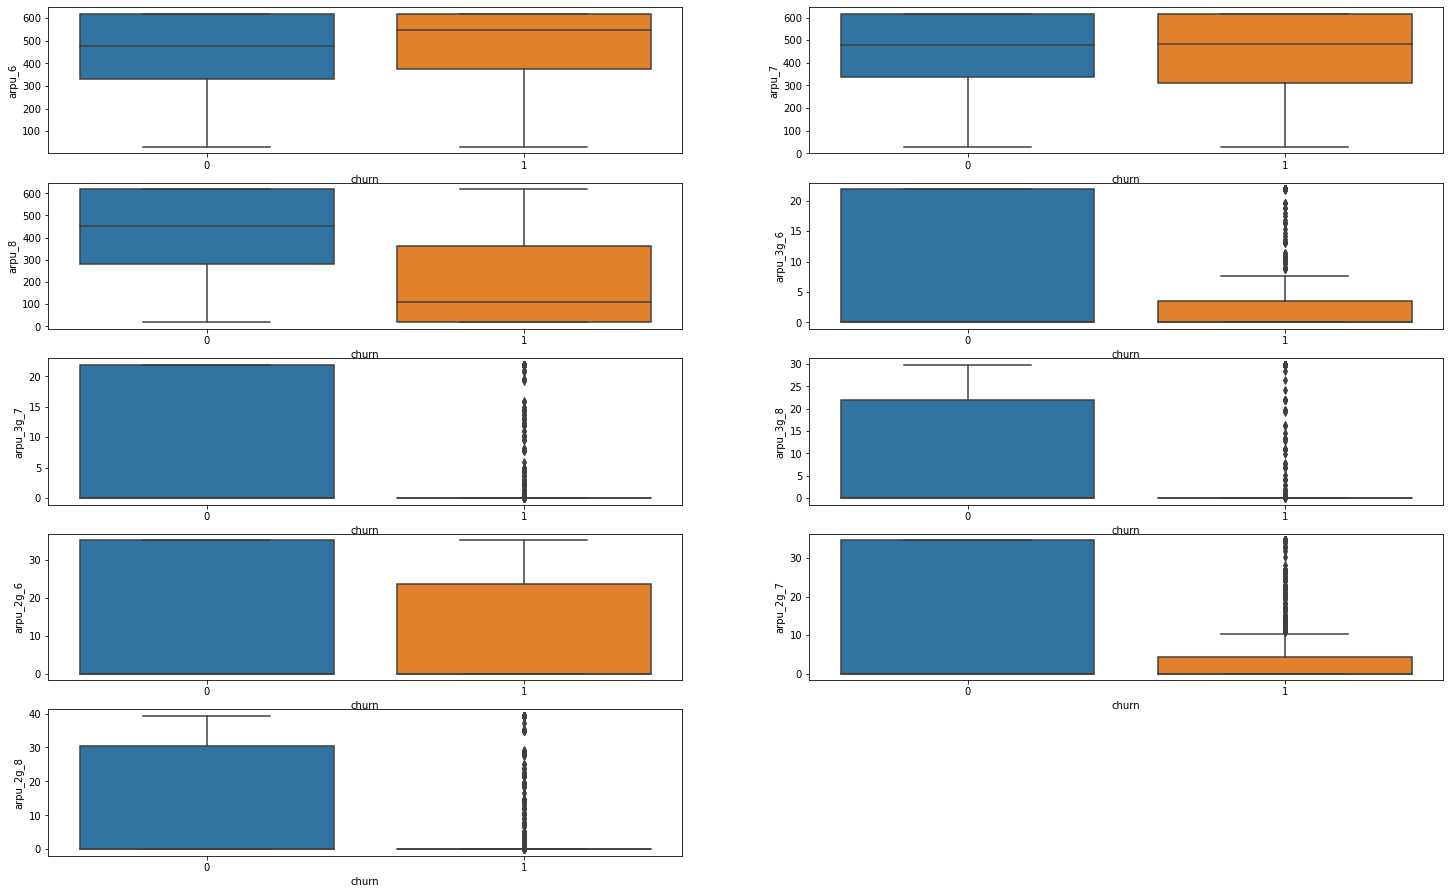

In [84]:
cat_plots(arpu)

1. For arpu features June and July, the median value is almost the same across the categories (Churn-1 and Not Churn-0) indicating that this does not influence the target variable. For August, the median is lower indicating that customers are probably churning in this month.
2. For arpu_2g and arpu_3g, the median value is almost 0 across both categories for all months indicating low influence on the target variable.

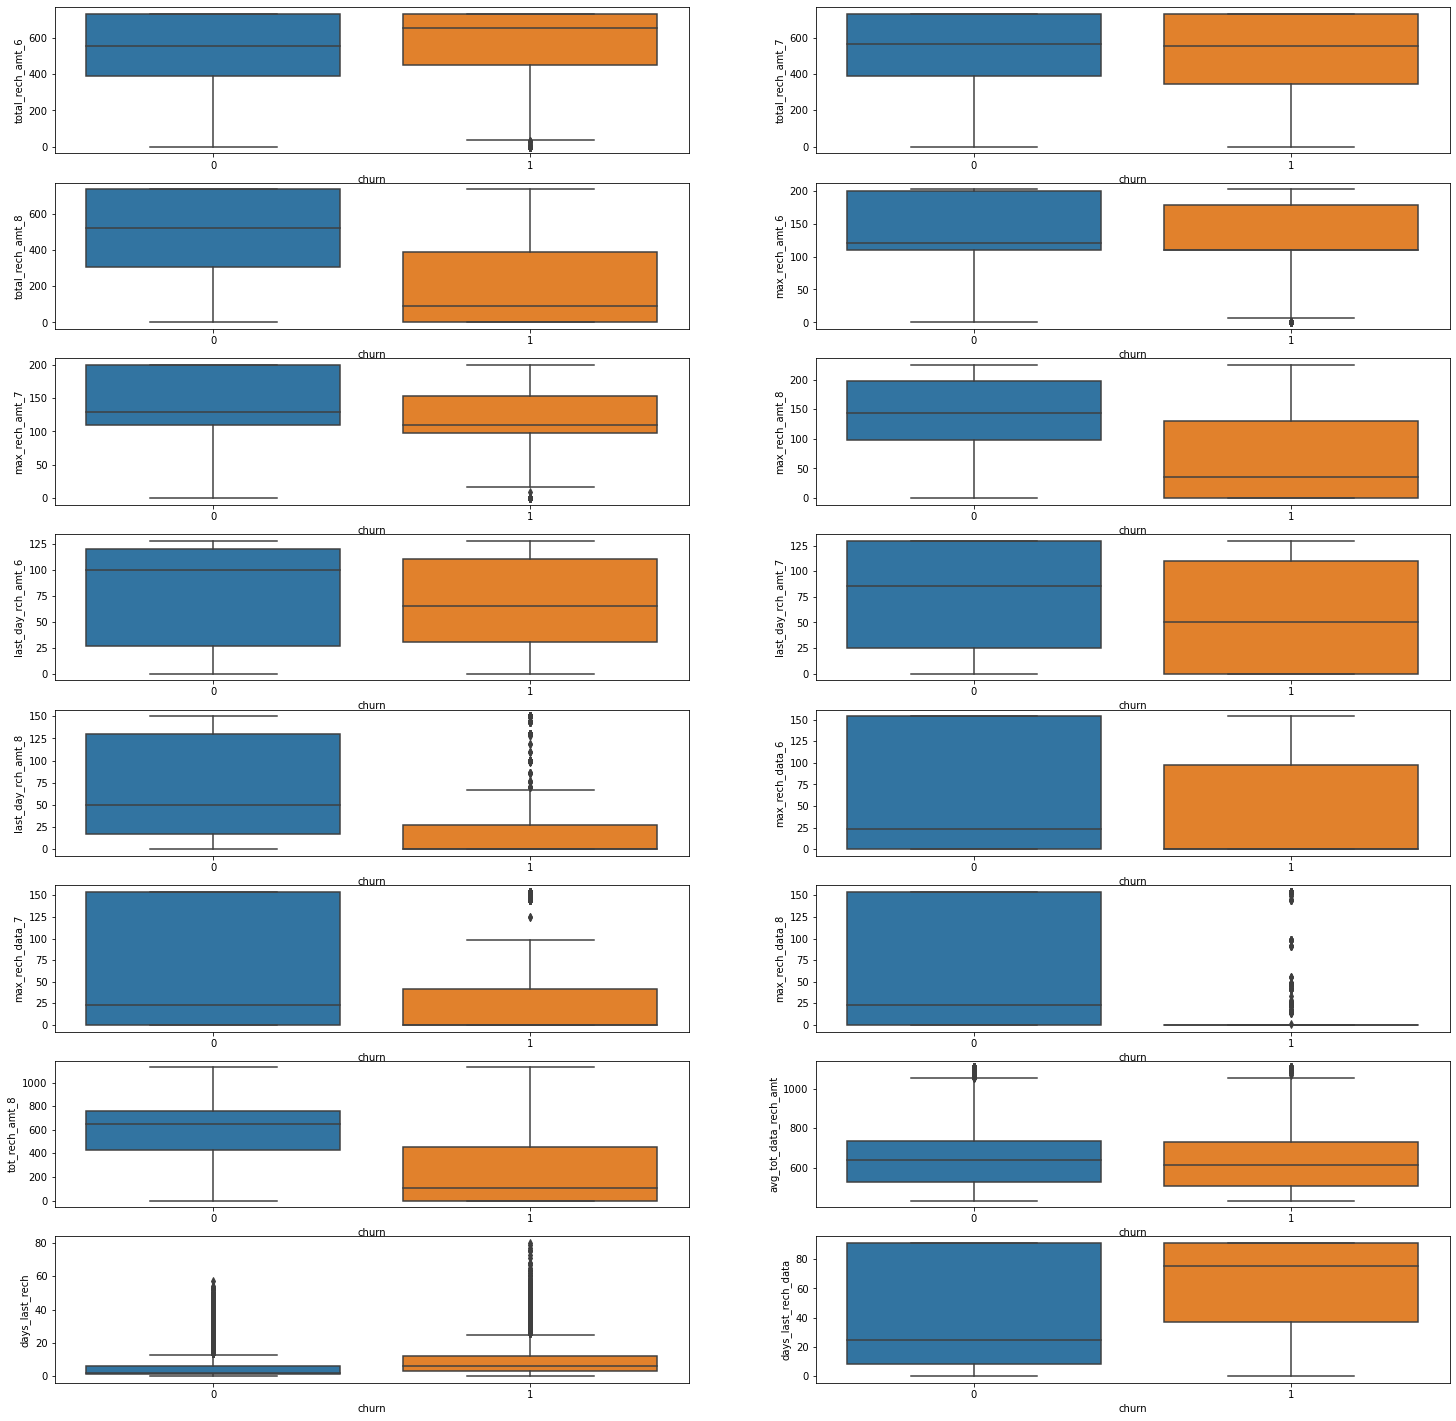

In [85]:
cat_plots(rech)

1. total_rech_amt, max_rech_amt, last_day_rech, : The median is almost same across the categories (Churn-1 and Not Churn-0) indicating that this does not influence the target variable. For August, the median is lower indicating that customers are probably churning in this month.
2. max_rech_data, avg_tot_data_rech_amt, day_last_rech: The median value is almost similar across the categories with median = 0 for Churn =0 and median =0 for Churn=1 indicating very low influence on the target variable.
3. tot_rech_amt: The median value for Churn 0 is 610 approx and median value for Churn 1 is amlomost 100 indicating influence on the target variable.
4. days_last_rech_data: The median value for Churn 0 is 25 approx and median value for Churn 1 is amlmost 70 indicating influence on the target variable.

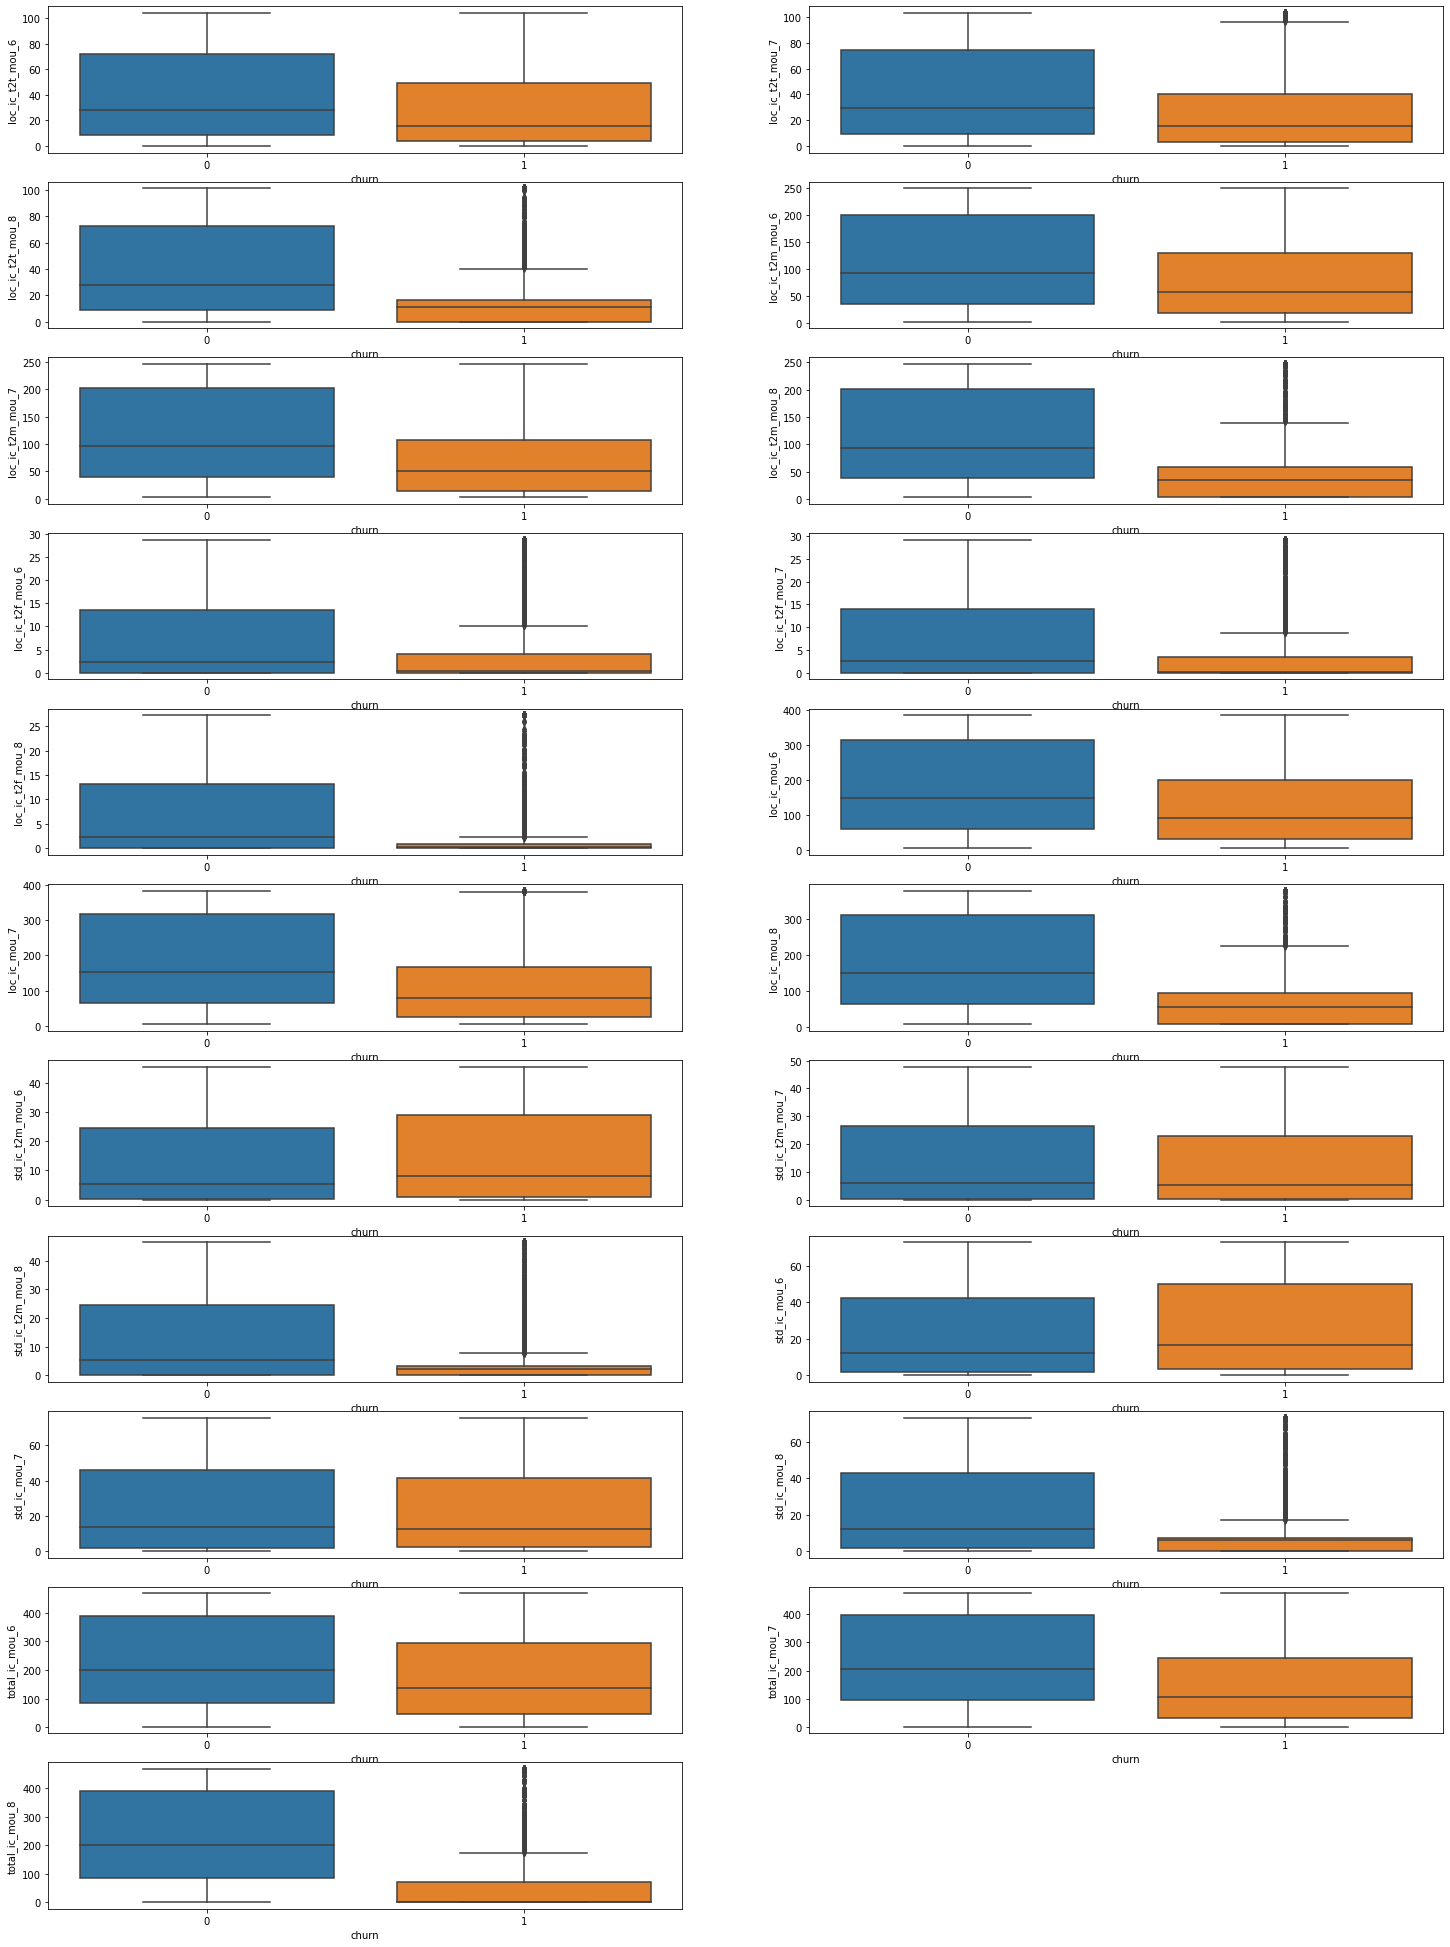

In [86]:
cat_plots(ic)

1. Local calls (t2t),Local calls (t2m), Local calls (t2f): The difference in the median for the categories for June-August is small indicating slight influence on target variable.
2. Local calls (t2t),Local calls (t2m), Local calls (t2f),Local calls: The difference in the median for the categories for June-August is small indicating slight influence on target variable.
3. STD (t2m) , STD: The median values are almost similar across the categories from June -August and the difference in median is also less indicating very less influence on target variable
4. Total incoming: The median values are almost similar across categories (Churn-1 and Not Churn-0) for June and July while for August the difference in the medians is higher indicating more customers are churning in the month of August.

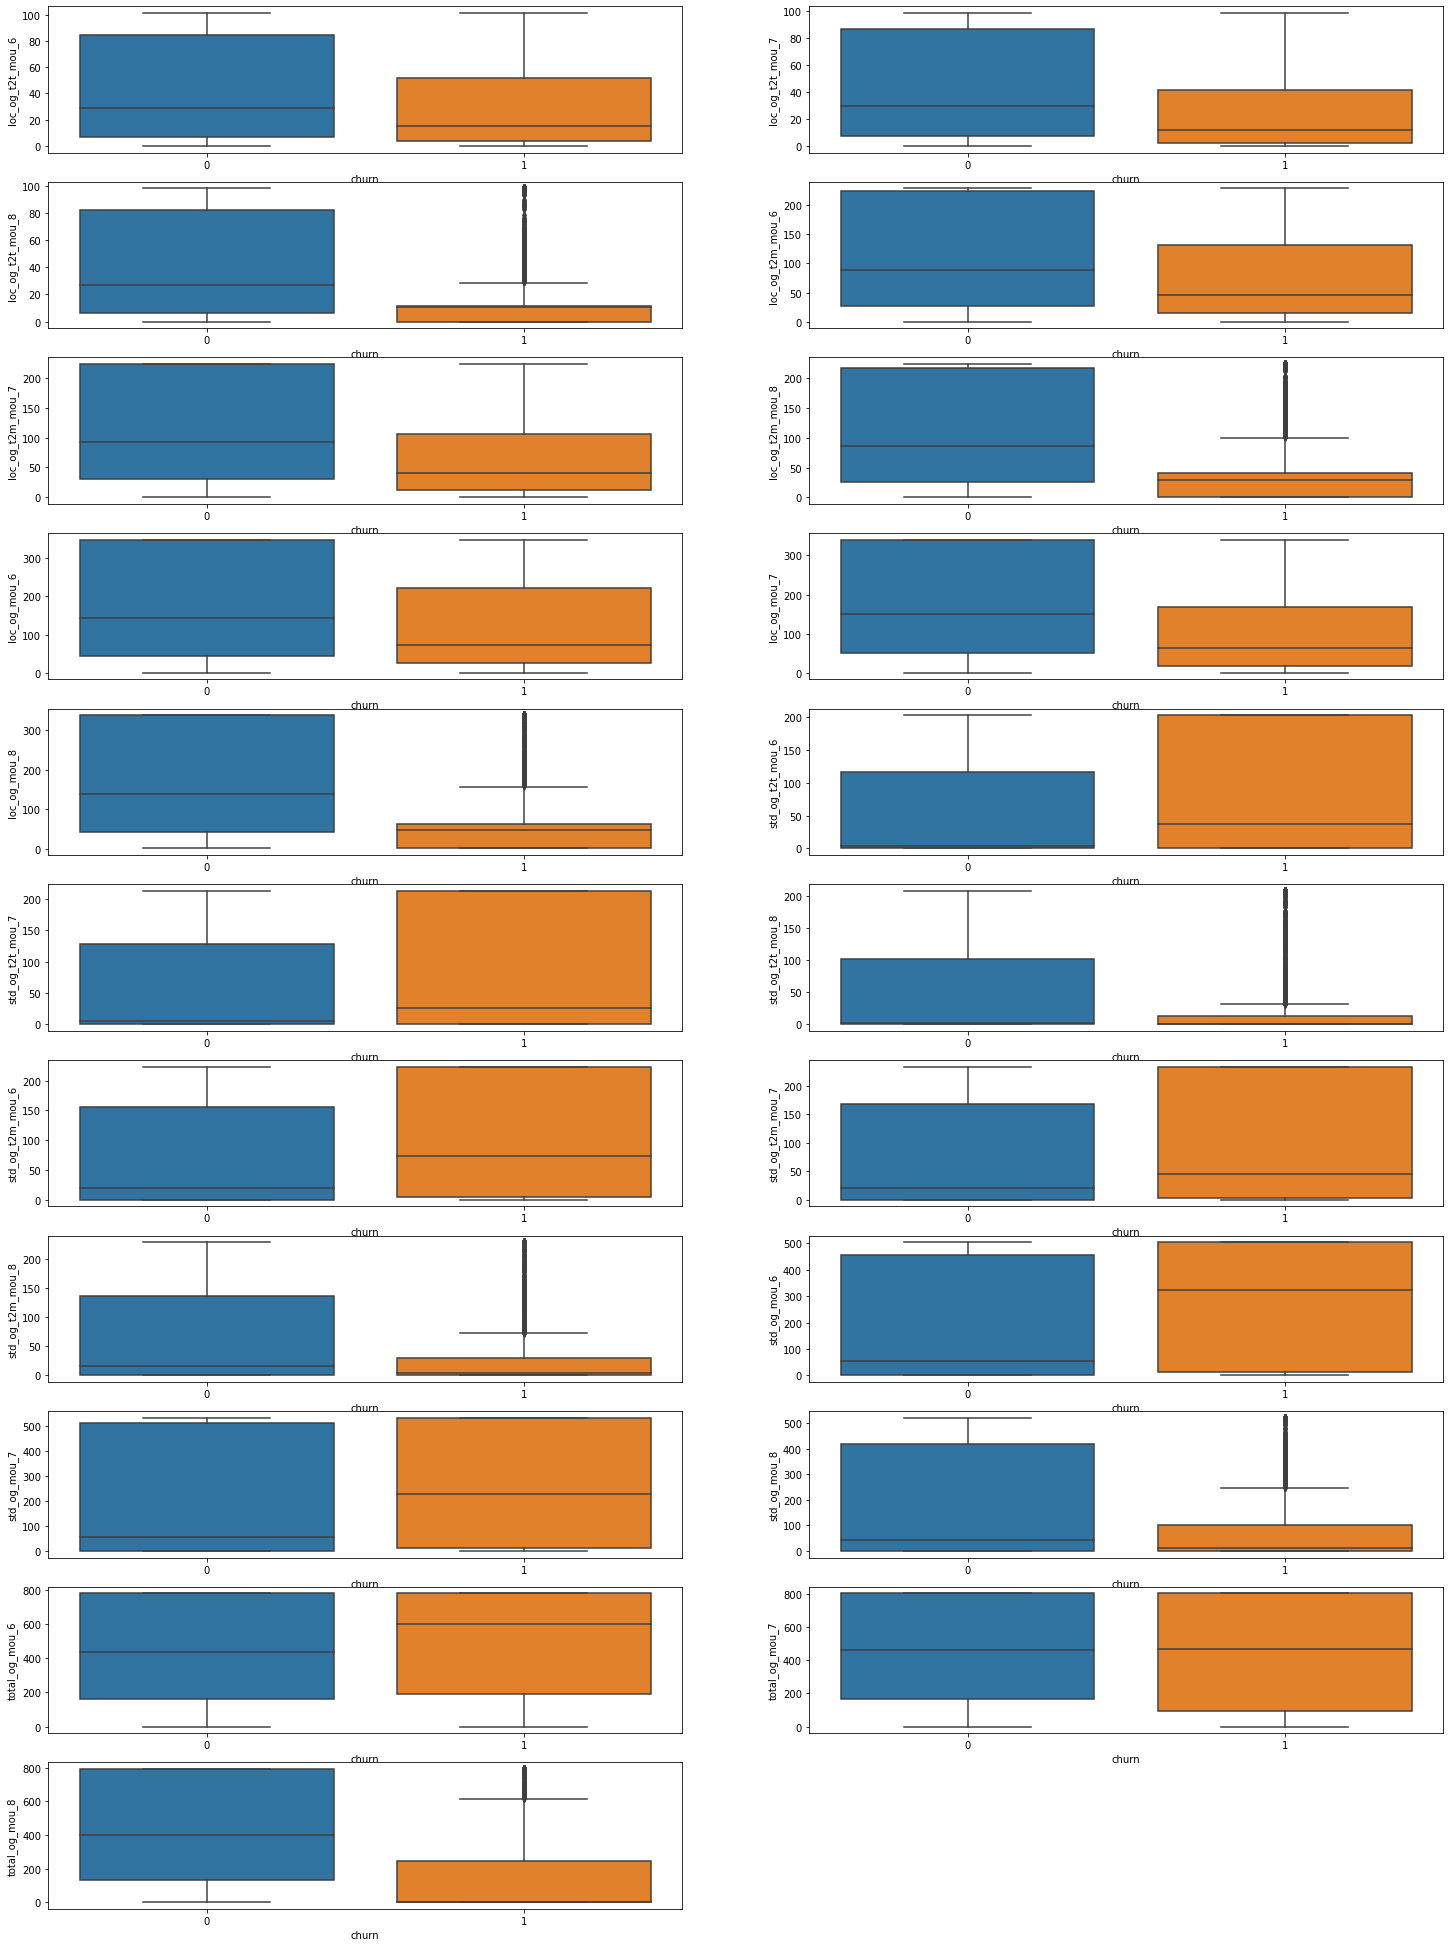

In [87]:
cat_plots(og)

1. Local calls (t2t),Local calls (t2m),Local calls,STD (t2t): The median values are similar across the three months June-August with some difference in the medians indicating slight influence on the target variable.
2. STD (t2m): The median values for month of June have some difference across the 2 categories and this difference seem to decrease in the month of July and August indicating influence on the target variable.
3. STD (MOU): The median values for month of June have significant difference across the 2 categories, and this difference seems to decrease in the month of July and August indicating influence on the target variable.
4. Total(MOU): The median values for month of June and July have slight difference across the 2 categories and a significant difference for August indicating influence on the target variable.

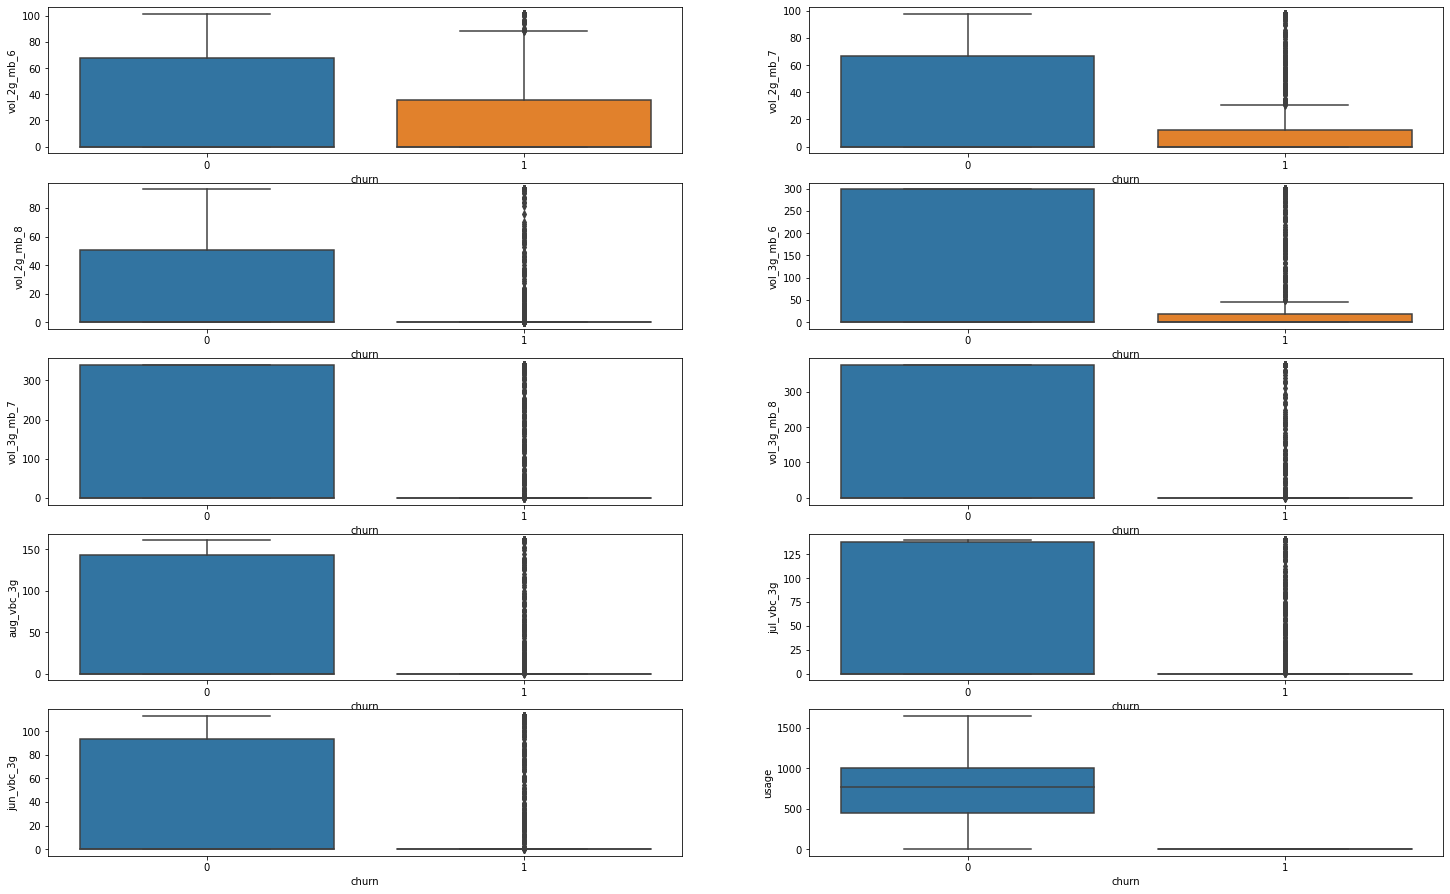

In [88]:
cat_plots(vvu)

- vol_2g_mb ,vol_3g_mb,jun_vbc_3g,aug_vbc_3g,jul_vbc_3g: The median value is almost 0 across both categories for all months indicating low influence on the target variable.
- usage: The median value for Churn = 0 is approx. 800 while for Churn = 1 is 0 indicating strong influence on the target variable.

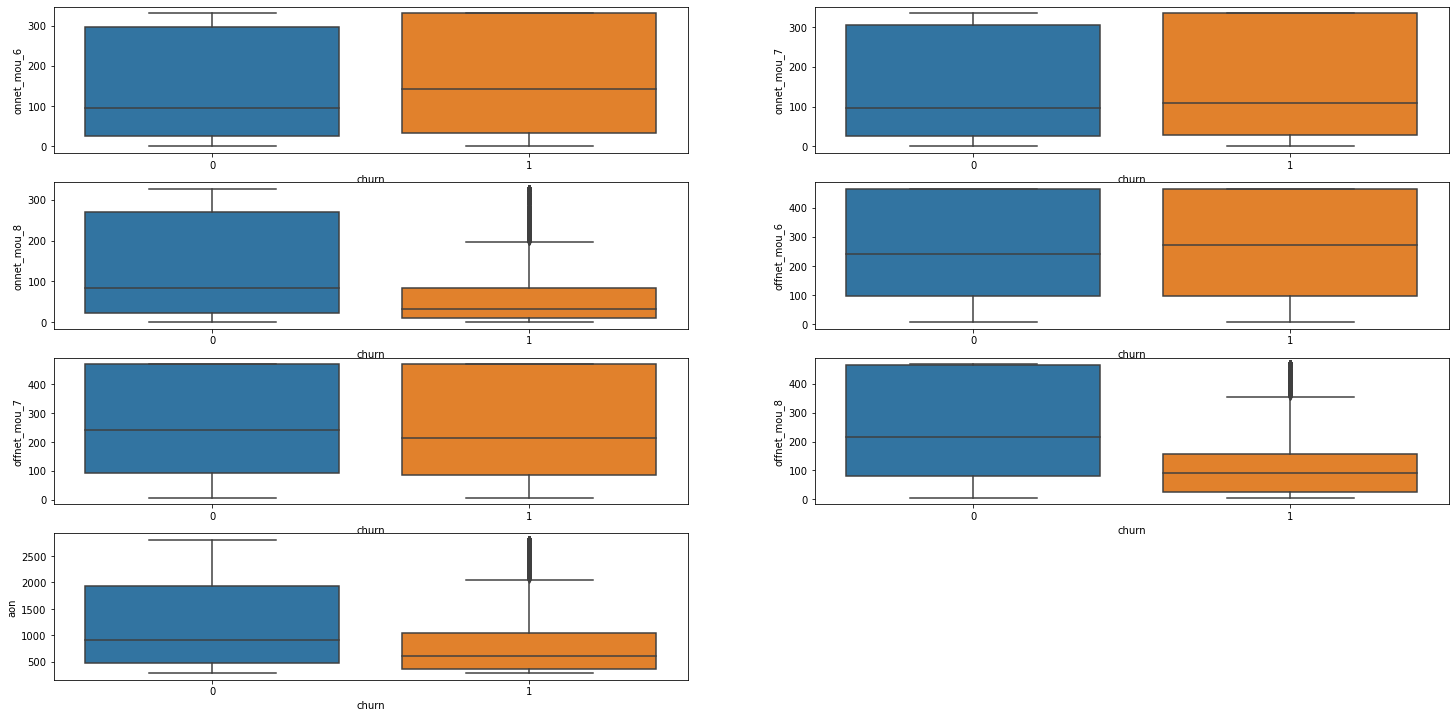

In [89]:
cat_plots(ooa)

- onnet and offnet features: The median for June and  July are almost similar across both categories while for August we see a slgiht drop across the categories. 
- aon: AON shows a slight difference in the median across the categories indicating mild influence on the target variable. 

In [90]:
#Converting to int type to check correlated variables
tele['churn']=tele['churn'].astype(int)

- The high_corr function has been defined to get the features that are highly correlated with another. The function takes in the value of correlation and data and outputs a dictionary with features as keys and the corresponding highly correlated features as values.  
- A correlation value of 0.7 has been chosen.

In [91]:
def high_corr(cor_value,data):
    dnc = data.corr()
    dnc1 = dnc[abs(dnc)>cor_value]
    d = dict([(i,list(dnc1[dnc1[i].notnull()].index)) for i in dnc1.columns])
    d1 = d.copy()
    return dict([(key,d1[key]) for key in d.keys() if len(d[key])!=0])

In [92]:
hc=high_corr(0.7,tele)

In [93]:
hc

{'arpu_6': ['arpu_6', 'total_rech_amt_6'],
 'arpu_7': ['arpu_7', 'total_rech_amt_7'],
 'arpu_8': ['arpu_8', 'total_og_mou_8', 'total_rech_amt_8', 'tot_rech_amt_8'],
 'onnet_mou_6': ['onnet_mou_6',
  'onnet_mou_7',
  'onnet_mou_8',
  'std_og_t2t_mou_6'],
 'onnet_mou_7': ['onnet_mou_6',
  'onnet_mou_7',
  'onnet_mou_8',
  'std_og_t2t_mou_7'],
 'onnet_mou_8': ['onnet_mou_6',
  'onnet_mou_7',
  'onnet_mou_8',
  'std_og_t2t_mou_8',
  'total_og_mou_8'],
 'offnet_mou_6': ['offnet_mou_6', 'offnet_mou_7', 'total_og_mou_6'],
 'offnet_mou_7': ['offnet_mou_6',
  'offnet_mou_7',
  'offnet_mou_8',
  'total_og_mou_7'],
 'offnet_mou_8': ['offnet_mou_7', 'offnet_mou_8', 'total_og_mou_8'],
 'loc_og_t2t_mou_6': ['loc_og_t2t_mou_6',
  'loc_og_t2t_mou_7',
  'loc_og_t2t_mou_8',
  'loc_og_mou_6',
  'loc_ic_t2t_mou_6'],
 'loc_og_t2t_mou_7': ['loc_og_t2t_mou_6',
  'loc_og_t2t_mou_7',
  'loc_og_t2t_mou_8',
  'loc_og_mou_7',
  'loc_ic_t2t_mou_7'],
 'loc_og_t2t_mou_8': ['loc_og_t2t_mou_6',
  'loc_og_t2t_mou_7',
 

In [94]:
#Getting the top 10 features that are most correlated with churn
churn_corr = tele.corr()['churn'].reset_index()
churn_corr.columns = ['Feature','Correlation']
churn_corr['Correlation']=abs(churn_corr['Correlation'])
churn_corr = churn_corr.sort_values(by='Correlation',ascending=False).reset_index(drop=True)
imp_var = churn_corr.loc[:11,'Feature']

Based on the dictionary defined above and business knowledge, we will be plotting heatmaps to check correlation:
1. Average revenue per user and total recharge amount 
2. Local outgoing - total outgoing, onnet, offnet
3. Local incoming - total incoming, onnet, offnet
4. STD outgoing - total outgoing, onnet, offnet
5. STD incoming - total incoming, onnet, offnet
6. Max. Recharge (Data) - Vol (data usage volume), arpu_2g, arpu_3g, vbc (volume based cost)

#### Correlations amongst independent variables

In [95]:
set1 = [i for i in tele.columns if (('arpu' in i)&('g' not in i))|('tot_rech_amt' in i)|('total_rech_amt' in i)]
set2 = [i for i in tele.columns if ('loc_og' in i)|('onnet' in i)|('total_og_mou' in i)|('offnet' in i)]
set3 = [i for i in tele.columns if ('loc_ic' in i)|('onnet' in i)|('total_ic_mou' in i)|('offnet' in i)]
set4 = [i for i in tele.columns if ('std_og' in i)|('onnet' in i)|('total_og_mou' in i)|('offnet' in i)]
set5 = [i for i in tele.columns if ('std_ic' in i)|('onnet' in i)|('total_ic_mou' in i)|('offnet' in i)]
set6 = [i for i in tele.columns if (('arpu' in i)&('g' in i))|('vbc' in i)|('vol' in i)|('max_rech_data' in i)]

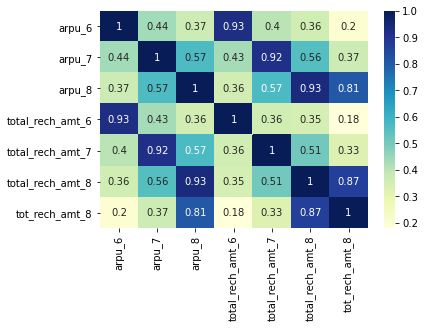

In [96]:
sns.heatmap(tele[set1].corr(), annot=True, cmap='YlGnBu')
plt.show()

- For each month, there is high correlation between arpu and total recharge amt. 
- There is slightly low correlation between the months of arpu features. A similar trend is seen with total recharge amt features. 

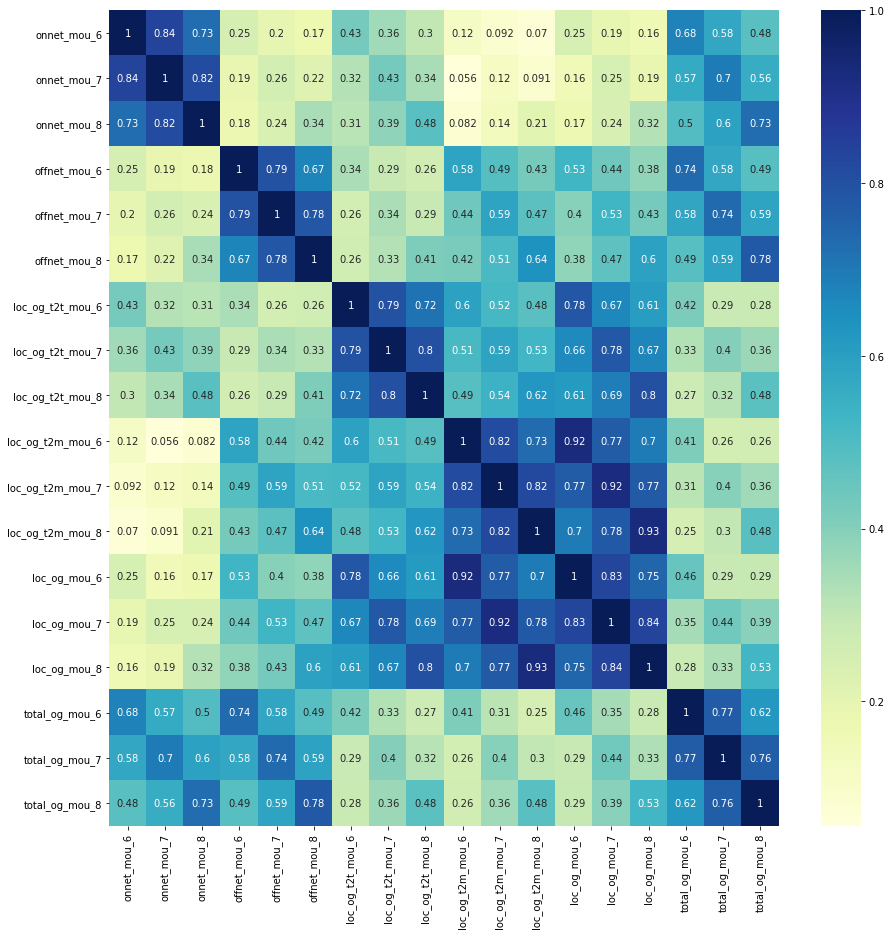

In [97]:
plt.figure(figsize=(15,15))
sns.heatmap(tele[set2].corr(), annot=True, cmap='YlGnBu')
plt.show()

1. Onnet, Offnet, loc_og_t2t_mou, loc_og_t2m_mou, loc_og_mou, total_og_mou:There is high correlation amongst the three months. 
2. Loc_og_mou has high correlation loc_og_t2t_mou, loc_og_t2m_mou across Jun-Aug.
3. tot_og_mou has high correlation with offnet features.

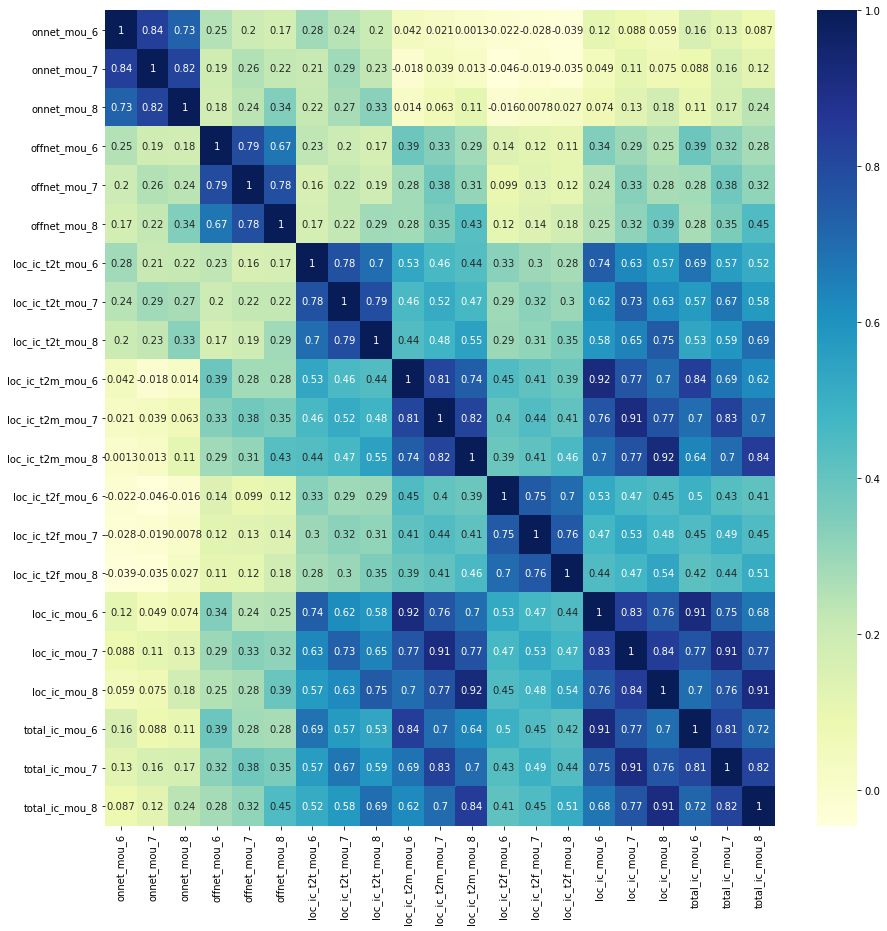

In [98]:
plt.figure(figsize=(15,15))
sns.heatmap(tele[set3].corr(), annot=True, cmap='YlGnBu')
plt.show()

1. Onnet, Offnet, loc_ic_t2t_mou, loc_ic_t2m_mou, loc_ic_t2f_mou, loc_ic_mou, total_ic_mou:There is high correlation amongst the three months. 
2. loc_ic_t2t_mou, loc_ic_t2m_mou have high correlation with each other across Jun-Aug.
3. Loc_ic_mou has high correlation loc_ic_t2t_mou, loc_ic_t2m_mou across Jun-Aug.
4. tot_ic_mou has high correlation loc_ic_t2t_mou, loc_ic_t2m_mou, loc_ic_mou across Jun-Aug.

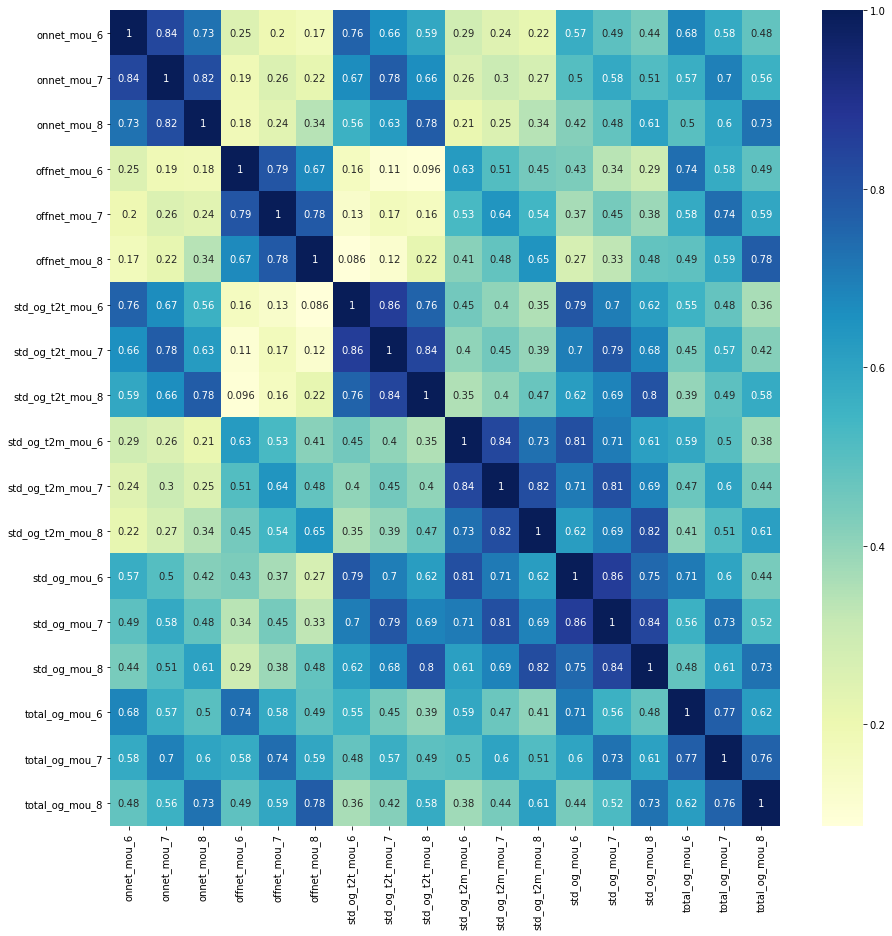

In [99]:
plt.figure(figsize=(15,15))
sns.heatmap(tele[set4].corr(), annot=True, cmap='YlGnBu')
plt.show()

1. Onnet, Offnet, std_og_t2t_mou, std_og_t2m_mou, std_og_mou, total_og_mou: There is high correlation amongst the three months. 
2. std_og_mou has high correlation std_og_t2t_mou, std_og_t2m_mou, total_og_mou across Jun-Aug.
3. tot_ic_mou has slightly high correlation with std_og_mou across Jun-Aug.

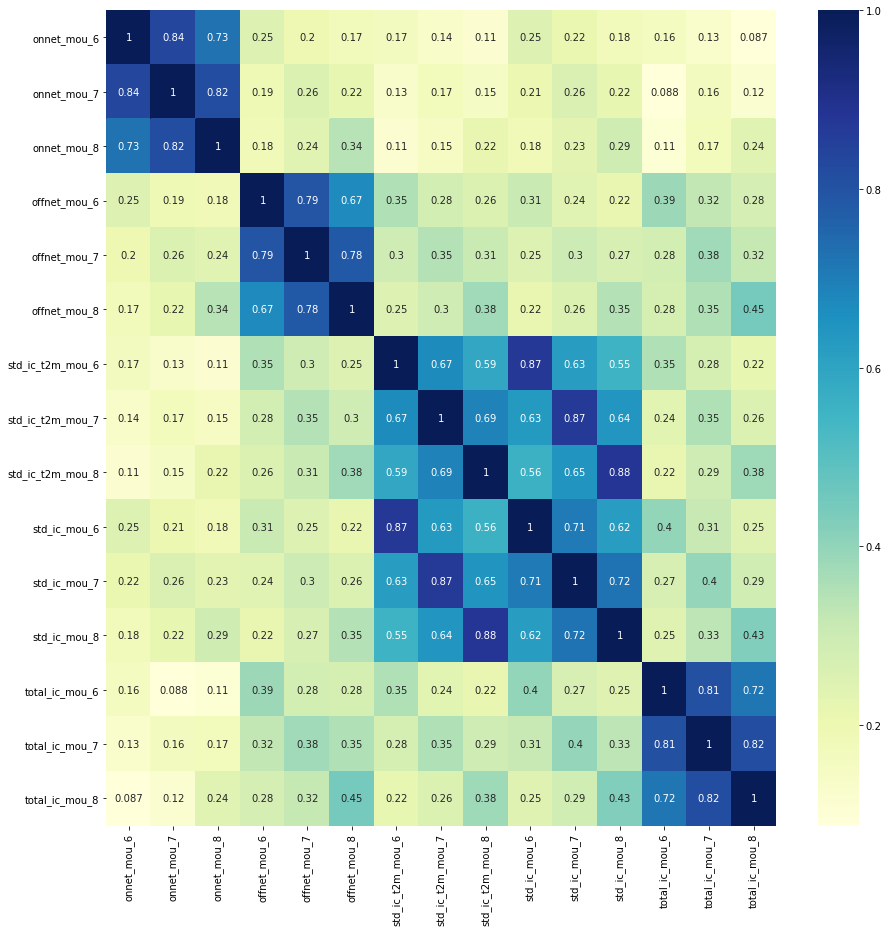

In [100]:
plt.figure(figsize=(15,15))
sns.heatmap(tele[set5].corr(), annot=True, cmap='YlGnBu')
plt.show()

1. Onnet, Offnet,  std_ic_t2m_mou, std_ic_mou, total_ic_mou:There is high correlation amongst the three months. 
2. std_ic_t2m_mou, std_ic_mou have high correlation with each other across Jun-Aug.

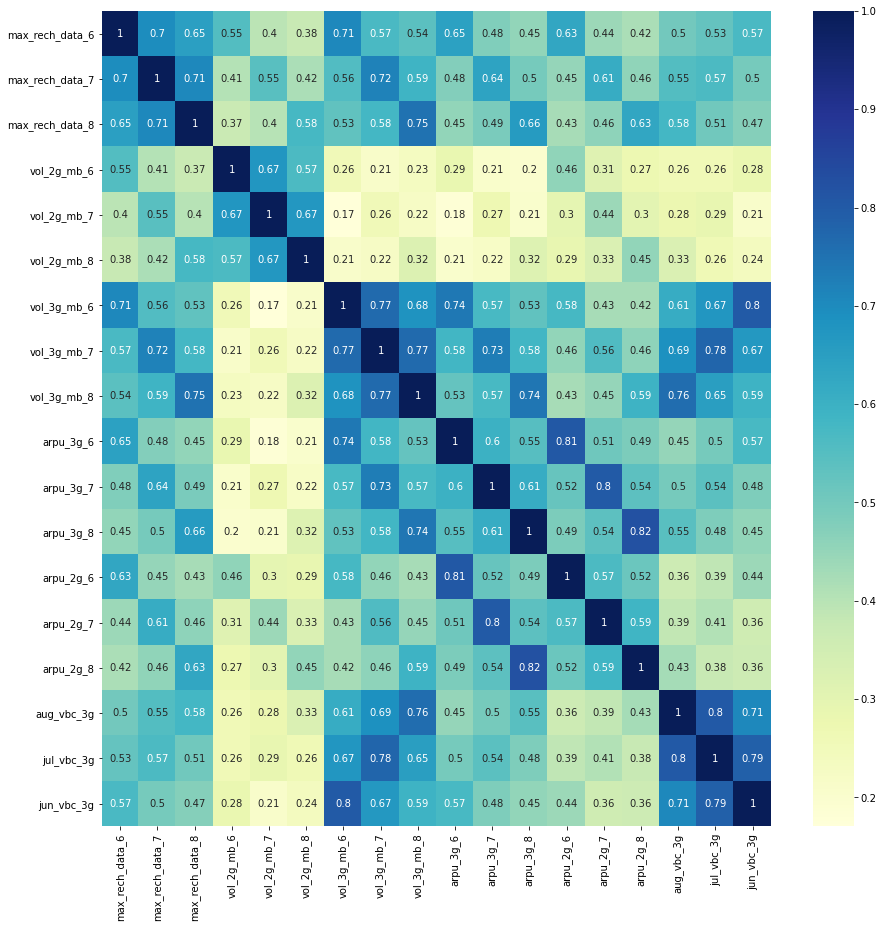

In [101]:
plt.figure(figsize=(15,15))
sns.heatmap(tele[set6].corr(), annot=True, cmap='YlGnBu')
plt.show()

1. max_rech_data,vol_2g,vol_3g,arpu_2g,arpu_3g:There is high correlation amongst the three months. 
2. max_rech_data: has correlation with vol_3g and slight correlation with vol_2g ,arpu_2g,arpu_3g 
3. vol_3g :-has correlation with arpu_2g,arpu_3g, jul_vbc_3g, jun_vbc_3g
4. aug_vbc_3g : has high correlation across all three months with vol_3g , and high correlation with jul_vbc_3g, jun_vbc_3g and slight correlation with max_rech_data across 3 months.

#### Correlation with 'churn' variable

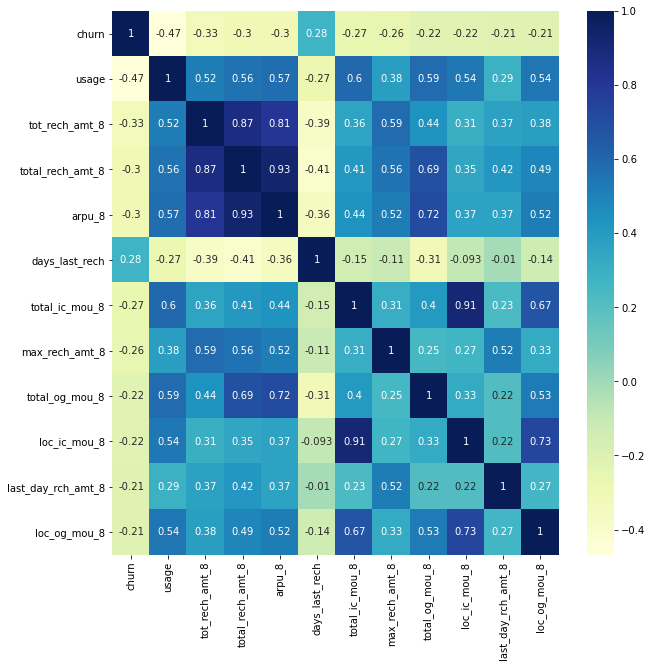

In [102]:
plt.figure(figsize=(10,10))
sns.heatmap(tele[imp_var].corr(), annot=True, cmap='YlGnBu')
plt.show()

## Modelling

### Train-test split

In [103]:
#Converting back to categorical for modelling
tele['churn']=tele['churn'].astype('category')

In [104]:
#Setting seed = 0 to makes sure the same random set of rows are chosen each time 
np.random.seed(0)

#Splitting data into train and test (80-20 split is being done)
X_train, X_test = train_test_split(tele, train_size = 0.8, test_size = 0.2)

In [105]:
print(X_train.shape)
print(X_test.shape)

(24015, 88)
(6004, 88)


### Scaling

- The StandardScaler is chosen as there are still outliers present. 
- We scale only the numerical variables. 

In [106]:
#Defining list of continuous type variables again, after dropping
num = list(tele.select_dtypes(include=['float64','int64']).columns)
scaler=StandardScaler()

X_train[num] = scaler.fit_transform(X_train[num])

In [107]:
# Dividing into X and Y sets for model building
y_train = X_train.pop('churn')
X_train = X_train

### SMOTE for class imbalance

- As mentioned earlier, there is class imbalance in the target variable. Thus SMOTE (Synthetic Minority Oversampling TEchnique) was used to handle this. 
- Since there are categorical independent variables in the data, SMOTENC is used.

In [108]:
categ = [i for i in range(0,tele.shape[1]) if 'fb_user' in tele.columns[i]]

In [109]:
assert list(tele.iloc[0,categ].index) == ['fb_user_6', 'fb_user_7', 'fb_user_8']

In [110]:
smote = SMOTENC(categ,random_state=0)

# fit predictor and target variable
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

#### Before SMOTE:

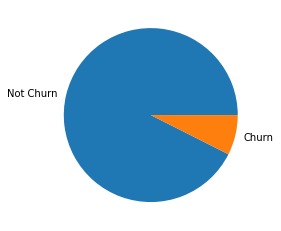

In [111]:
plt.pie(pd.value_counts(tele['churn']), labels = ['Not Churn','Churn'])
plt.show()

#### After SMOTE

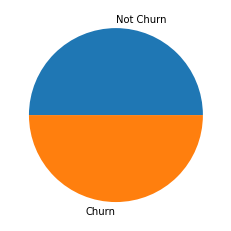

In [112]:
plt.pie(pd.value_counts(y_train_smote), labels = ['Not Churn','Churn'])
plt.show()

In [113]:
assert X_train_smote.isnull().any().sum()==0

- The draw_roc function has been defined to plot roc curves for model evaluation purposes. It takes in the actual and predicted values of the target variable and the title of the curve as input and gives an roc_auc cruve as output.

In [114]:
def draw_roc(actual, probs, t):
    fpr, tpr, thresholds = metrics.roc_curve(actual, probs, drop_intermediate = False )
    auc_score = metrics.roc_auc_score(actual, probs)
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title(t)
    plt.legend(loc="lower right")
    plt.show()

### PCA

- Since there are over 80 features, dimensionality reduction using PCA is done and applied to different algorithms.
- A value of 0.9 is given to pca() to choose the number of features, i.e., optimal number of features that explain at least 90% variability.
- There is also multicollinearity in the data. PCA is being used to handle this as well.

In [115]:
pca = PCA(0.9, random_state=0)

In [116]:
#Fitting PCA model to training data
X_train_pca = pca.fit_transform(X_train_smote)

In [117]:
#Checking number of features remaining
X_train_pca.shape

(44466, 25)

- According to the PCA algorithm, only 25 features are required to predict the target variable

<AxesSubplot:>

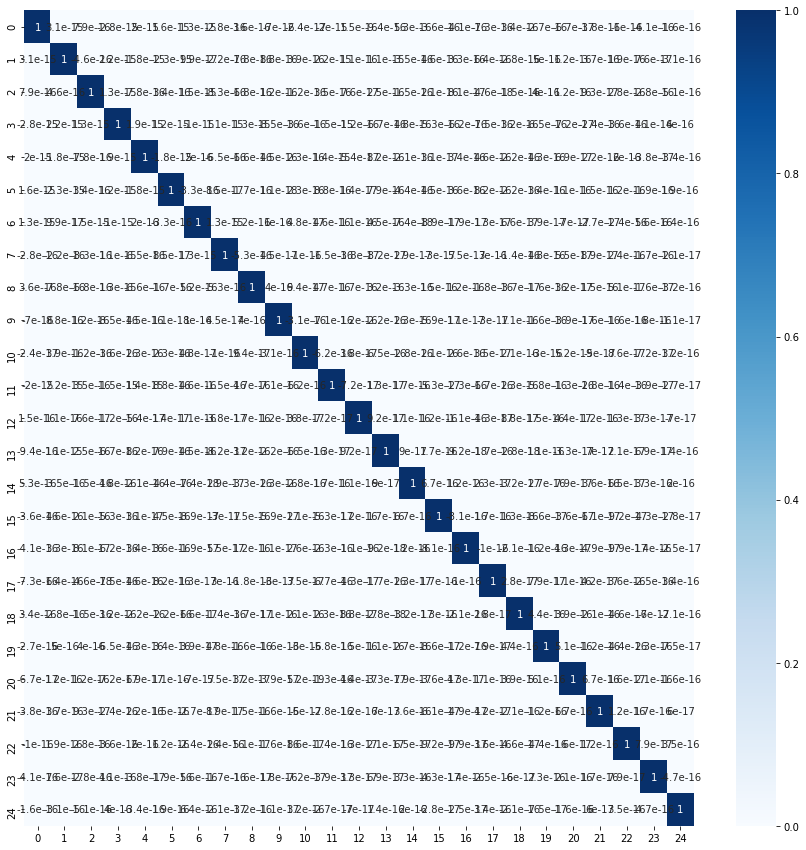

In [118]:
#Checking that there is no more multicollinearity in the data 
corrmat = np.corrcoef(X_train_pca.transpose())
plt.figure(figsize=[15,15])
sns.heatmap(corrmat, annot=True, cmap='Blues')

In [119]:
#Scaling test data with training data set's scaler and transforming using pca
X_test[num]=scaler.transform(X_test[num])

y_test = X_test.pop('churn')
X_test = X_test

X_test_pca = pca.transform(X_test)
X_test_pca.shape

(6004, 25)

In [120]:
var_cumu = np.cumsum(pca.explained_variance_ratio_)

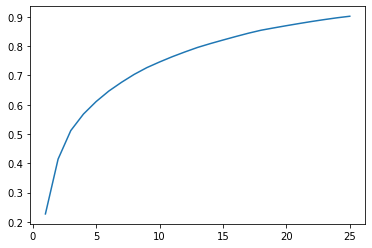

In [121]:
plt.plot(range(1,len(var_cumu)+1), var_cumu)

- The Scree plot also shows that the optimal number of features to be used is 25

### Model Building and Evaluation

1. Each model is fitted to two versions of the data: the original dataset and the PCA transformed dataset. These are then compared.
2. The different algorithms are compared as well. Different models used:
    - Logistic Regression
    - Decision Tree
    - Random Forest (Bagging)
3. Comparison has been done based on these evaluation metrics:
    - Accuracy
    - Precision
    - Recall
    - F1 score
    - ROC curve (and ROC_AUC score)
4. Since we are more concerned about Churners than Non-Churners, Recall score is given slightly higher weightage when comparing. Having said that, he main goal still is to have a balance between the metrics.
5. A random_state of 0 is used everywhere. 

### Logistic Regression

- Automatic feature selection is done using RFE.

In [122]:
rfe = RFE(LogisticRegression(), 25) #Considering 25 predictors as suggested by PCA
rfe=rfe.fit(X_train_smote,y_train_smote)

In [123]:
rfe_col = X_train_smote.columns[rfe.support_]

X_train_rfe = X_train_smote[rfe_col]

- Since there will still be some multicollinearity in the data, regularization needs to be done.
- Hyperparameter tuning is used to choose best form of regularisation - A GridSearchCV is used.

In [124]:
log_r = LogisticRegression(random_state=0)

params = {'C': [0.1, 10, 100, 500, 1000], 'penalty':['l1','l2']}


# cross validation
folds = 5
model_cv = GridSearchCV(estimator = log_r, 
                        param_grid = params, 
                        scoring= 'recall',  
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            
model_cv.fit(X_train_rfe, y_train_smote)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


GridSearchCV(cv=5, estimator=LogisticRegression(random_state=0),
             param_grid={'C': [0.1, 10, 100, 500, 1000],
                         'penalty': ['l1', 'l2']},
             return_train_score=True, scoring='recall', verbose=1)

In [125]:
c=model_cv.best_params_['C']
p=model_cv.best_params_['penalty']

In [126]:
#Best parameters models is fit to training data
log_lasso = LogisticRegression(C=c,penalty=p,random_state=0).fit(X_train_rfe,y_train_smote)

In [127]:
#Predicting probabilities of each category (0/1) for each value
y_train_lr_pred_prob = log_lasso.predict_proba(X_train_rfe)

In [128]:
y_train_lr_pred_prob = pd.DataFrame(y_train_lr_pred_prob)
y_train_lr_pred_prob=y_train_lr_pred_prob.iloc[:,[1]]
y_train_lr_pred_prob.head()

,1
0,9.297281e-71
1,6.157235e-12
2,1.047593e-55
3,5.815626e-92
4,2.904749e-80


In [129]:
#If probability is greater than 0.5, we consider it as Churn (1), else Not Churn (0)
y_train_lr_pred = y_train_lr_pred_prob[1].map(lambda x: 1 if x > 0.5 else 0)

In [130]:
# Confusion matrix 
confusion = metrics.confusion_matrix(y_train_smote, y_train_lr_pred)
print(confusion)

[[21908   325]
 [    0 22233]]


- The evalm function is being defined to make a tabular form of the evaluation metrics for each model for ease of comparison and model selection. 
- It takes in model name, actual and predicted values of the target variable as input and gives the dataframe containing Accuracy, Precision, Recall and F1 score of the model as output.

In [131]:
eval_metrics = pd.DataFrame([[0,0,0,0,0]])
def evalm(model_name,actual,pred,eval_metrics1=eval_metrics):
    eval_metrics1.columns=['Model','Accuracy','Precision','Recall','F1-Score']
    eval_metrics1['Model'] = model_name
    eval_metrics1.loc[eval_metrics1['Model'] ==model_name,'Accuracy'] = round(metrics.accuracy_score(actual, pred),3)
    eval_metrics1.loc[eval_metrics1['Model'] ==model_name,'Precision'] = round(metrics.precision_score(actual, pred),3)
    eval_metrics1.loc[eval_metrics1['Model'] ==model_name,'Recall'] = round(metrics.recall_score(actual, pred),3)
    eval_metrics1.loc[eval_metrics1['Model'] ==model_name,'F1-Score'] = round(metrics.f1_score(actual, pred),3)
    return eval_metrics1

In [132]:
met=evalm('Logistic Reg+RFE_Train',y_train_smote, y_train_lr_pred).copy()

In [133]:
met

,Model,Accuracy,Precision,Recall,F1-Score
0,Logistic Reg+RFE_Train,0.993,0.986,1.0,0.993


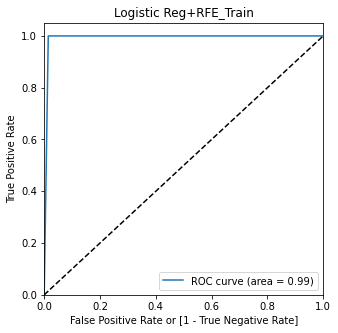

In [134]:
#Plotting ROC curve
draw_roc(y_train_smote, y_train_lr_pred, 'Logistic Reg+RFE_Train')

In [135]:
#Keeping only required columns in test set
X_test_lr = X_test[X_train_rfe.columns]

In [136]:
#Exploring test set
X_test.head()

,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,loc_og_t2t_mou_6,...,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,usage,tot_rech_amt_8,avg_tot_data_rech_amt,days_last_rech,days_last_rech_data
29091,-0.665162,0.654811,0.857909,-0.712894,-0.927943,-0.682522,-0.056814,-0.119410,0.579717,0.104046,...,0.0,0.126784,1.705172,-0.652942,0.793282,1.357681,-0.182409,-0.198563,-0.690349,0.103167
18616,1.028845,1.028355,1.079973,1.460844,1.460782,1.584257,1.241062,1.242297,1.350538,1.546340,...,1.0,0.831463,1.705172,1.662387,1.707413,1.726440,1.021235,1.350023,-0.546070,-0.807121
3161,0.059711,-0.042436,-0.552661,-0.335077,0.702261,0.336553,0.179105,0.970072,-0.034892,1.516858,...,0.0,-0.557203,-0.639811,-0.652942,-0.627262,-0.205853,-0.836490,-0.867408,-0.401790,1.254414
12253,1.028845,1.028355,1.079973,0.455643,0.201521,0.130418,1.241062,1.242297,1.350538,1.546340,...,0.0,-0.852639,-0.639811,-0.652942,-0.627262,0.487553,0.502016,1.551882,-0.546070,-0.298430
13343,0.086741,-0.609958,-0.541722,-0.468085,-0.703124,-0.348723,0.174378,-0.586689,0.170383,1.075661,...,1.0,-0.733085,-0.639811,1.662387,1.707413,0.399704,-0.098120,0.397974,-0.113231,-1.074853


In [137]:
#Predicting on the test set
y_test_lr_pred = log_lasso.predict(X_test_lr)

In [138]:
met=met.append(evalm('Logistic Reg+RFE_Test',y_test, y_test_lr_pred),ignore_index=True)

In [139]:
met

,Model,Accuracy,Precision,Recall,F1-Score
0,Logistic Reg+RFE_Train,0.993,0.986,1.0,0.993
1,Logistic Reg+RFE_Test,0.989,0.869,1.0,0.930


- The train and test accuracy and recall are quite similar but there is a reduce in Precision (significant reduce) and F1 score from train to test. This could be an indication of possible overfitting.

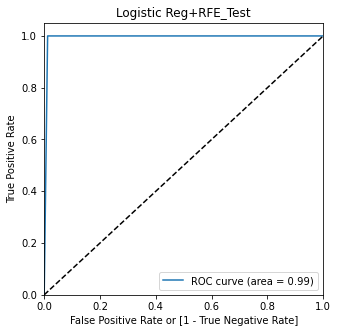

In [140]:
draw_roc(y_test, y_test_lr_pred, 'Logistic Reg+RFE_Test')

### Logistic Regression with PCA

In [141]:
#Logistic regression model is fit on PCA transformed training sets
log_pca = LogisticRegression(random_state=0).fit(X_train_pca,y_train_smote)

In [142]:
y_train_pca_pred = log_pca.predict(X_train_pca)

In [143]:
met=met.append(evalm('Logistic Reg_Train+PCA',y_train_smote, y_train_pca_pred),ignore_index=True)

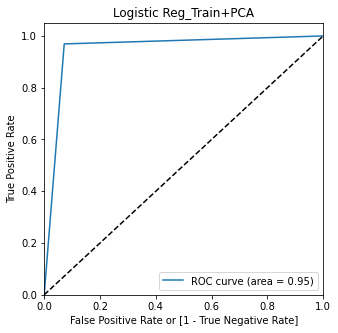

In [144]:
draw_roc(y_train_smote, y_train_pca_pred,'Logistic Reg_Train+PCA')

In [145]:
y_test_pca_pred = log_pca.predict(X_test_pca)

In [146]:
met=met.append(evalm('Logistic Reg_Test+PCA',y_test, y_test_pca_pred),ignore_index=True)

In [147]:
met

,Model,Accuracy,Precision,Recall,F1-Score
0,Logistic Reg+RFE_Train,0.993,0.986,1.000,0.993
1,Logistic Reg+RFE_Test,0.989,0.869,1.000,0.930
2,Logistic Reg_Train+PCA,0.949,0.931,0.969,0.950
3,Logistic Reg_Test+PCA,0.934,0.534,0.945,0.682


- All metrics of Logistic Regression + PCA are consdierably lower when compared to Logistic Regression + RFE. There is an especially large drop in Precision and F1 Score, even between Train and test of Logistic Regression + PCA.
- This model will most likely not be consdiered.

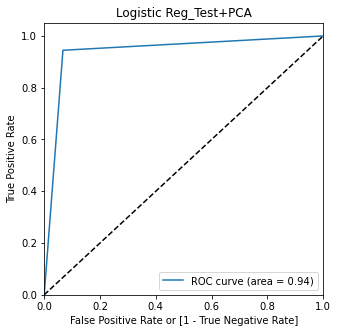

In [148]:
draw_roc(y_test, y_test_pca_pred,'Logistic Reg_Test+PCA')

- There is a drop in the roc_auc score as well when compared to Logistic Regression + RFE.

### Decision Tree

In [182]:
dt = DecisionTreeClassifier(random_state=0)

In [183]:
params = {
    'max_depth': [10, 15, 20, 25, 30],
    'min_samples_leaf': [5, 10, 20, 50, 100],
    'criterion': ["gini", "entropy"]
}

In [184]:
grid_search_dt = GridSearchCV(estimator=dt, 
                           param_grid=params, 
                           cv=5, n_jobs=-1, verbose=1, scoring = "recall")

In [185]:
grid_search_dt.fit(X_train_smote, y_train_smote)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=0), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [10, 15, 20, 25, 30],
                         'min_samples_leaf': [5, 10, 20, 50, 100]},
             scoring='recall', verbose=1)

In [186]:
grid_search_dt.best_estimator_

DecisionTreeClassifier(max_depth=10, min_samples_leaf=5, random_state=0)

In [187]:
dt_best=grid_search_dt.best_estimator_

In [155]:
y_train_dt = dt_best.predict(X_train_smote)

met=met.append(evalm('Decision Tree_Train',y_train_smote, y_train_dt),ignore_index=True)

met

,Model,Accuracy,Precision,Recall,F1-Score
0,Logistic Reg+RFE_Train,0.993,0.986,1.000,0.993
1,Logistic Reg+RFE_Test,0.989,0.869,1.000,0.930
2,Logistic Reg_Train+PCA,0.949,0.931,0.969,0.950
3,Logistic Reg_Test+PCA,0.934,0.534,0.945,0.682
4,Decision Tree_Train,1.000,1.000,1.000,1.000


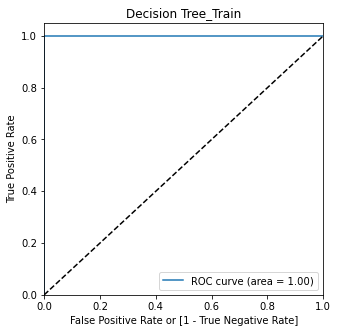

In [156]:
draw_roc(y_train_smote, y_train_dt,'Decision Tree_Train')

In [157]:
y_test_dt = dt_best.predict(X_test)

met=met.append(evalm('Decision Tree_Test',y_test, y_test_dt),ignore_index=True)

met

,Model,Accuracy,Precision,Recall,F1-Score
0,Logistic Reg+RFE_Train,0.993,0.986,1.000,0.993
1,Logistic Reg+RFE_Test,0.989,0.869,1.000,0.930
2,Logistic Reg_Train+PCA,0.949,0.931,0.969,0.950
3,Logistic Reg_Test+PCA,0.934,0.534,0.945,0.682
4,Decision Tree_Train,1.000,1.000,1.000,1.000
5,Decision Tree_Test,1.000,1.000,1.000,1.000


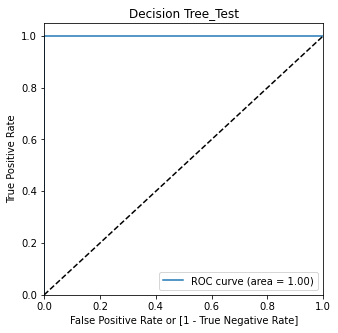

In [158]:
draw_roc(y_test, y_test_dt,'Decision Tree_Test')

- Both train and test scores for the Decision Tree model are all 1 and therefore outperforms logistic regression.
- Decision trees are not affected by multicollinearity in features as if there were highly correlated features, the decision tree would consider only one of them for splitting. This could be a possible reason for decision tree's better performance.

#### With PCA

In [159]:
grid_search_dt.fit(X_train_pca, y_train_smote)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=0), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [10, 15, 20, 25, 30],
                         'min_samples_leaf': [5, 10, 20, 50, 100]},
             scoring='recall', verbose=1)

In [160]:
dt_best_pca=grid_search_dt.best_estimator_

In [161]:
y_train_dt_pca = dt_best_pca.predict(X_train_pca)

met=met.append(evalm('Decision Tree_Train+PCA',y_train_smote, y_train_dt_pca),ignore_index=True)

met

,Model,Accuracy,Precision,Recall,F1-Score
0,Logistic Reg+RFE_Train,0.993,0.986,1.000,0.993
1,Logistic Reg+RFE_Test,0.989,0.869,1.000,0.930
2,Logistic Reg_Train+PCA,0.949,0.931,0.969,0.950
3,Logistic Reg_Test+PCA,0.934,0.534,0.945,0.682
4,Decision Tree_Train,1.000,1.000,1.000,1.000
5,Decision Tree_Test,1.000,1.000,1.000,1.000
6,Decision Tree_Train+PCA,0.969,0.960,0.980,0.970


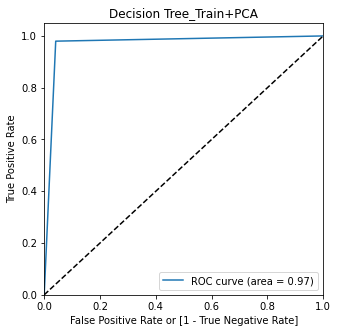

In [162]:
draw_roc(y_train_smote, y_train_dt_pca,'Decision Tree_Train+PCA')

In [163]:
y_test_dt_pca = dt_best.predict(X_test_pca)

met=met.append(evalm('Decision Tree_Test+PCA',y_test, y_test_dt_pca),ignore_index=True)

met

,Model,Accuracy,Precision,Recall,F1-Score
0,Logistic Reg+RFE_Train,0.993,0.986,1.000,0.993
1,Logistic Reg+RFE_Test,0.989,0.869,1.000,0.930
2,Logistic Reg_Train+PCA,0.949,0.931,0.969,0.950
3,Logistic Reg_Test+PCA,0.934,0.534,0.945,0.682
4,Decision Tree_Train,1.000,1.000,1.000,1.000
5,Decision Tree_Test,1.000,1.000,1.000,1.000
6,Decision Tree_Train+PCA,0.969,0.960,0.980,0.970
7,Decision Tree_Test+PCA,0.901,0.410,0.710,0.520


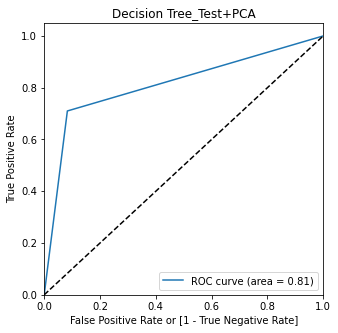

In [164]:
draw_roc(y_test, y_test_dt_pca,'Decision Tree_Test+PCA')

- There is a drop in all metrics for Decision Tre + PCA model when compared with the Decision Tree model. 
- There is also a considerable drop from the train to test set metrics.
- The AUC has decreased by almost 17% from train to test set.
- The overall performance of Decision Tre + PCA models is even poorer than the logistic regression models.

### Random Forest - Bagging algorithm

In [165]:
classifier_rf = RandomForestClassifier(random_state=0, n_jobs=-1)

In [166]:
#Hyperparameter tuning
params = {
    'max_depth': [30, 40],
    'min_samples_leaf': [50, 100],
    'max_features': ['auto','sqrt'],
    'min_samples_split':[100,150]
}

In [167]:
grid_search_rf = GridSearchCV(estimator=classifier_rf, param_grid=params, 
                          cv=5, n_jobs=-1, verbose=1, scoring = "recall")

In [168]:
grid_search_rf.fit(X_train_smote,y_train_smote)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(n_jobs=-1, random_state=0),
             n_jobs=-1,
             param_grid={'max_depth': [30, 40],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [50, 100],
                         'min_samples_split': [100, 150]},
             scoring='recall', verbose=1)

In [169]:
rf_best = grid_search_rf.best_estimator_

In [170]:
y_train_rf = rf_best.predict(X_train_smote)

met=met.append(evalm('Random Forest_Train',y_train_smote, y_train_rf),ignore_index=True)

met

,Model,Accuracy,Precision,Recall,F1-Score
0,Logistic Reg+RFE_Train,0.993,0.986,1.000,0.993
1,Logistic Reg+RFE_Test,0.989,0.869,1.000,0.930
2,Logistic Reg_Train+PCA,0.949,0.931,0.969,0.950
3,Logistic Reg_Test+PCA,0.934,0.534,0.945,0.682
4,Decision Tree_Train,1.000,1.000,1.000,1.000
5,Decision Tree_Test,1.000,1.000,1.000,1.000
6,Decision Tree_Train+PCA,0.969,0.960,0.980,0.970
7,Decision Tree_Test+PCA,0.901,0.410,0.710,0.520
8,Random Forest_Train,1.000,1.000,1.000,1.000


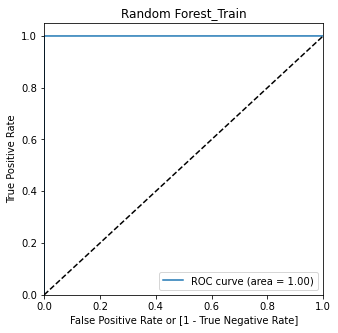

In [171]:
draw_roc(y_train_smote, y_train_rf,'Random Forest_Train')

In [172]:
y_test_rf = rf_best.predict(X_test)

met=met.append(evalm('Random Forest_Test',y_test, y_test_rf),ignore_index=True)

met

,Model,Accuracy,Precision,Recall,F1-Score
0,Logistic Reg+RFE_Train,0.993,0.986,1.000,0.993
1,Logistic Reg+RFE_Test,0.989,0.869,1.000,0.930
2,Logistic Reg_Train+PCA,0.949,0.931,0.969,0.950
3,Logistic Reg_Test+PCA,0.934,0.534,0.945,0.682
4,Decision Tree_Train,1.000,1.000,1.000,1.000
5,Decision Tree_Test,1.000,1.000,1.000,1.000
6,Decision Tree_Train+PCA,0.969,0.960,0.980,0.970
7,Decision Tree_Test+PCA,0.901,0.410,0.710,0.520
8,Random Forest_Train,1.000,1.000,1.000,1.000
9,Random Forest_Test,1.000,1.000,0.998,0.999


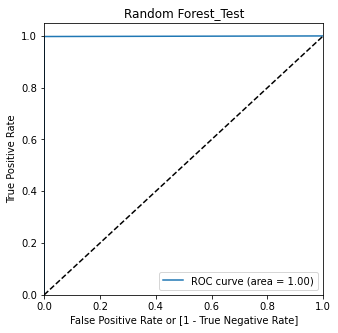

In [173]:
draw_roc(y_test, y_test_rf,'Random Forest_Test')

- The random forest classifier shows similar performance as the decision tree, with all metrics for the training set as 1 and almost 1 for the test set (Recall and F1 score have a differenc of 0.002 and 0.001). 
- Due to this infitesimal difference, decision tree model may be preferred over the random forest.

#### Random Forest with PCA

In [174]:
grid_search_rf.fit(X_train_pca,y_train_smote)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(n_jobs=-1, random_state=0),
             n_jobs=-1,
             param_grid={'max_depth': [30, 40],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [50, 100],
                         'min_samples_split': [100, 150]},
             scoring='recall', verbose=1)

In [175]:
rf_best = grid_search_rf.best_estimator_

In [176]:
y_train_rf_pca = rf_best.predict(X_train_pca)

met=met.append(evalm('Random Forest_Train+PCA',y_train_smote, y_train_rf_pca),ignore_index=True)

met

,Model,Accuracy,Precision,Recall,F1-Score
0,Logistic Reg+RFE_Train,0.993,0.986,1.000,0.993
1,Logistic Reg+RFE_Test,0.989,0.869,1.000,0.930
2,Logistic Reg_Train+PCA,0.949,0.931,0.969,0.950
3,Logistic Reg_Test+PCA,0.934,0.534,0.945,0.682
4,Decision Tree_Train,1.000,1.000,1.000,1.000
5,Decision Tree_Test,1.000,1.000,1.000,1.000
6,Decision Tree_Train+PCA,0.969,0.960,0.980,0.970
7,Decision Tree_Test+PCA,0.901,0.410,0.710,0.520
8,Random Forest_Train,1.000,1.000,1.000,1.000
9,Random Forest_Test,1.000,1.000,0.998,0.999


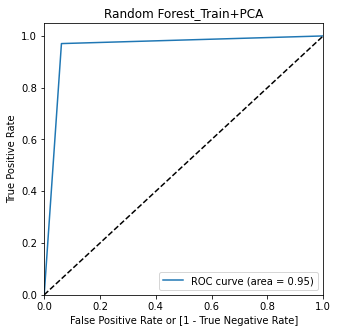

In [177]:
draw_roc(y_train_smote, y_train_rf_pca,'Random Forest_Train+PCA')

In [178]:
y_test_rf_pca = rf_best.predict(X_test_pca)

met=met.append(evalm('Random Forest_Test+PCA',y_test, y_test_rf_pca),ignore_index=True)

met

,Model,Accuracy,Precision,Recall,F1-Score
0,Logistic Reg+RFE_Train,0.993,0.986,1.000,0.993
1,Logistic Reg+RFE_Test,0.989,0.869,1.000,0.930
2,Logistic Reg_Train+PCA,0.949,0.931,0.969,0.950
3,Logistic Reg_Test+PCA,0.934,0.534,0.945,0.682
4,Decision Tree_Train,1.000,1.000,1.000,1.000
5,Decision Tree_Test,1.000,1.000,1.000,1.000
6,Decision Tree_Train+PCA,0.969,0.960,0.980,0.970
7,Decision Tree_Test+PCA,0.901,0.410,0.710,0.520
8,Random Forest_Train,1.000,1.000,1.000,1.000
9,Random Forest_Test,1.000,1.000,0.998,0.999


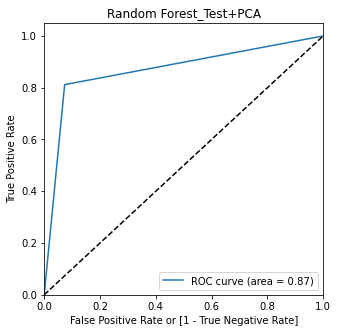

In [179]:
draw_roc(y_test, y_test_rf_pca,'Random Forest_Test+PCA')

- There is a slight decrease in the Random Forest_Train+PCA metrics when compared to Random Forest_Train but there is a considerable differnce between Random Forest_Test+PCA and Random Forest_Test and also Random Forest_Train+PCA and Random Forest_Test+PCA metrics.
- The Random_Forest PCA model still performs better than the Decision Tree_PCA model but is poorer than the remaining models.

### Model Selection

In [180]:
met

,Model,Accuracy,Precision,Recall,F1-Score
0,Logistic Reg+RFE_Train,0.993,0.986,1.000,0.993
1,Logistic Reg+RFE_Test,0.989,0.869,1.000,0.930
2,Logistic Reg_Train+PCA,0.949,0.931,0.969,0.950
3,Logistic Reg_Test+PCA,0.934,0.534,0.945,0.682
4,Decision Tree_Train,1.000,1.000,1.000,1.000
5,Decision Tree_Test,1.000,1.000,1.000,1.000
6,Decision Tree_Train+PCA,0.969,0.960,0.980,0.970
7,Decision Tree_Test+PCA,0.901,0.410,0.710,0.520
8,Random Forest_Train,1.000,1.000,1.000,1.000
9,Random Forest_Test,1.000,1.000,0.998,0.999


- Based on overall evaluation metrics, it seems that the Decision Tree classifier without the PCA and with hyperparameter tuning is the best model.
- RandomForect without PCA is a close second.
- The PCA models have lower scores than the non-PCA models in general indicating that forced dimensionality reduction could have happened. 


#### Best model:

In [188]:
dt_best

DecisionTreeClassifier(max_depth=10, min_samples_leaf=5, random_state=0)

In [194]:
feature_imp = pd.DataFrame(sorted(zip(dt_best.feature_importances_,X_test.columns)), columns=['Value','Feature'])
feature_imp.sort_values(by="Value", ascending=False)

,Value,Feature
86,1.0,usage
55,0.0,std_ic_mou_6
63,0.0,std_og_mou_8
62,0.0,std_og_mou_7
61,0.0,std_og_mou_6
...,...,...
27,0.0,loc_ic_t2f_mou_8
26,0.0,loc_ic_t2f_mou_7
25,0.0,loc_ic_t2f_mou_6
24,0.0,loc_ic_mou_8


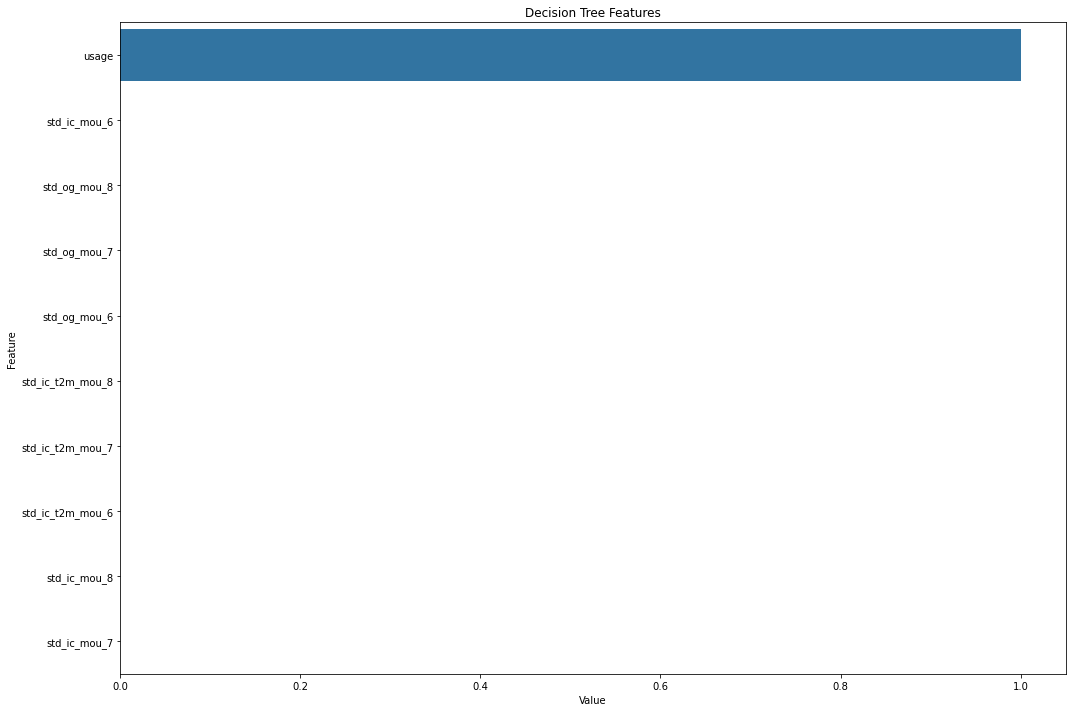

In [192]:
plt.figure(figsize=(15, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False).head(10))
plt.title('Decision Tree Features')
plt.tight_layout()
plt.show()

- Thus, a decision tree with max_depth=10, min_samples_leaf=5 is the best model. 
- The most important features are:

In [197]:
feature_imp.sort_values(by="Value", ascending=False)['Feature'].head(10).to_list()

['usage',
 'std_ic_mou_6',
 'std_og_mou_8',
 'std_og_mou_7',
 'std_og_mou_6',
 'std_ic_t2m_mou_8',
 'std_ic_t2m_mou_7',
 'std_ic_t2m_mou_6',
 'std_ic_mou_8',
 'std_ic_mou_7']

<b>Strategies to manage customer churn:</b>
1. Check usage of high value customers and if there is a risk of them churning then offer some new/cheaper schemes.